<a href="https://colab.research.google.com/github/Ajinkya-18/NeuroVision/blob/main/neurovision2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NeuroVision

## Dataset Processing for PyTorch

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import torch
from scipy import signal
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm  # Use notebook-friendly tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Starting to copy dataset folder from Drive to local storage...")
print("This may take a significant amount of time, please be patient.")

!cp -r "/content/drive/MyDrive/NeuroVision/gan_dataset" "/content/gan_dataset"

print("Copying complete!")

Starting to copy dataset folder from Drive to local storage...
This may take a significant amount of time, please be patient.
Copying complete!


In [ ]:
print("Starting to copy dataset folder from Drive to local storage...")
print("This may take a significant amount of time, please be patient.")

!cp -r "/content/drive/MyDrive/NeuroVision/gan_imagenet" "/content/gan_imagenet"

print("Copying complete!")

Starting to copy dataset folder from Drive to local storage...
This may take a significant amount of time, please be patient.
Copying complete!


In [ ]:
# ==============================================================================
# EEG DATA PREPARATION SCRIPT FOR GOOGLE COLAB
# ==============================================================================
# This single script handles the entire data setup process for a new Colab session.
# It copies data from Google Drive, preprocesses it into spectrograms,
# calculates normalization stats, and prepares DataLoaders for training.
#
# HOW TO USE:
# 1. Mount your Google Drive in a previous cell:
#    from google.colab import drive
#    drive.mount('/content/drive')
# 2. Update the configuration paths in the section below.
# 3. Run this entire cell.
# ==============================================================================

# --- 1. CONFIGURATION ---
# TODO: UPDATE THESE PATHS
GDRIVE_RAW_DATA_ROOT = Path('/content/drive/MyDrive/NeuroVision/gan_dataset') # Path to your 567-class folder in GDrive
LOCAL_RAW_DATA_ROOT = Path('/content/gan_dataset') # Temporary local copy for speed
LOCAL_PROCESSED_ROOT = Path('/content/processed_spectrograms') # Where local spectrograms will be saved

# --- Script Parameters ---
TRAIN_RATIO = 0.85
BATCH_SIZE = 64
IMG_SIZE = 224
NUM_WORKERS = 2 # Colab usually has 2 CPU cores

# --- Spectrogram Parameters ---
FS = 128
NPERSEG = 64
NOVERLAP = 32
NUM_CHANNELS = 4 # Assuming AF3, AF4, T7, T8

# ==============================================================================
# --- 2. DATASET CLASS DEFINITION ---
# ==============================================================================

class EEGSpectrogramDataset(Dataset):
    """
    Custom PyTorch Dataset for loading pre-computed EEG spectrogram tensors.
    """
    def __init__(self, samples, mode='finetune', img_size=224, mean=None, std=None, is_train=False):
        self.samples = samples
        self.mode = mode

        if not samples:
            raise ValueError("The 'samples' list cannot be empty.")
        if mode == 'finetune' and not isinstance(samples[0][1], (int, np.integer)):
             raise TypeError(f"In 'finetune' mode, labels must be integers. Got {type(samples[0][1])}")

        if mean is not None and std is not None:
            normalization = transforms.Normalize(mean=mean.tolist(), std=std.tolist())
        else:
            print("Warning: Mean and Std are not provided. Data will not be normalized.")
            normalization = transforms.Identity()

        if is_train:
            self.transform = transforms.Compose([
                transforms.ToDtype(torch.float32, scale=False),
                transforms.Resize((img_size, img_size), antialias=True),
                normalization,
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToDtype(torch.float32, scale=False),
                transforms.Resize((img_size, img_size), antialias=True),
                normalization,
            ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        spectrogram_path, label_idx = self.samples[idx]
        spectrogram = torch.load(spectrogram_path)
        transformed_spectrogram = self.transform(spectrogram)
        if self.mode == 'pretrain':
            return transformed_spectrogram
        else:
            return transformed_spectrogram, torch.tensor(label_idx, dtype=torch.long)

# ==============================================================================
# --- 3. HELPER AND SETUP FUNCTIONS ---
# ==============================================================================

def generate_spectrogram(eeg_data_1d, file_path):
    """Generates a spectrogram from a 1D EEG signal."""
    # This logic handles files with 4 or 5 channels, dropping Pz if present.
    if eeg_data_1d.shape[1] == 5:
        eeg_data_1d = eeg_data_1d[:, :-1]
    elif eeg_data_1d.shape[0] == 5:
        eeg_data_1d = eeg_data_1d.T[:, :-1]

    if eeg_data_1d.shape[1] != NUM_CHANNELS:
        if eeg_data_1d.shape[0] == NUM_CHANNELS:
            eeg_data_1d = eeg_data_1d.T
        else:
            raise ValueError(f"File {file_path} has an invalid shape: {eeg_data_1d.shape}")

    channel_spectrograms = []
    for i in range(NUM_CHANNELS):
        f, t, Sxx = signal.spectrogram(eeg_data_1d[:, i], fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP)
        channel_spectrograms.append(np.log1p(Sxx))
    return torch.tensor(np.array(channel_spectrograms), dtype=torch.float32)

def setup_data_for_session():
    """
    The main setup function to be run once per Colab session.
    """
    print("--- Starting Data Setup for Colab Session ---")

    # Step 1: Copy data from GDrive to local VM for faster I/O
    print(f"1. Copying raw data from '{GDRIVE_RAW_DATA_ROOT}' to '{LOCAL_RAW_DATA_ROOT}'...")
    if LOCAL_RAW_DATA_ROOT.exists():
        print("Local data directory already exists. Skipping copy.")
    else:
        shutil.copytree(GDRIVE_RAW_DATA_ROOT, LOCAL_RAW_DATA_ROOT)
    print("Copy complete.")

    # Step 2: Discover files, create splits, and process spectrograms
    print("2. Discovering files and creating train/val splits...")
    all_samples = []
    class_names = sorted([d.name for d in LOCAL_RAW_DATA_ROOT.iterdir() if d.is_dir()])
    class_to_idx = {name: i for i, name in enumerate(class_names)}
    for class_name, label_idx in class_to_idx.items():
        for file_path in (LOCAL_RAW_DATA_ROOT / class_name).glob('*.csv'):
            all_samples.append((file_path, label_idx))

    labels = [s[1] for s in all_samples]
    train_samples_raw, val_samples_raw = train_test_split(
        all_samples, train_size=TRAIN_RATIO, stratify=labels, random_state=42
    )

    train_samples_processed, val_samples_processed = [], []
    output_train_dir = LOCAL_PROCESSED_ROOT / 'train'
    output_val_dir = LOCAL_PROCESSED_ROOT / 'val'

    for split_name, raw_samples, processed_list, output_dir in [
        ('train', train_samples_raw, train_samples_processed, output_train_dir),
        ('val', val_samples_raw, val_samples_processed, output_val_dir)
    ]:
        print(f"3. Processing '{split_name}' split and saving to '{output_dir}'...")
        output_dir.mkdir(parents=True, exist_ok=True)
        for raw_path, label_idx in tqdm(raw_samples, desc=f"Processing {split_name}"):
            try:
                eeg_data = pd.read_csv(raw_path, header=None, index_col=0).iloc[:-1, :].values
                spectrogram_tensor = generate_spectrogram(eeg_data, raw_path)

                output_path = output_dir / f"{raw_path.stem}.pt"
                torch.save(spectrogram_tensor, output_path)
                processed_list.append((str(output_path), label_idx))
            except Exception as e:
                print(f"Could not process {raw_path}. Error: {e}")

    # Step 4: Calculate Mean and Std from the training set
    print("4. Calculating mean and std from training set...")
    count, mean, m2 = 0, torch.zeros(NUM_CHANNELS), torch.zeros(NUM_CHANNELS)
    for path, _ in tqdm(train_samples_processed, desc="Calculating stats"):
        spectrogram = torch.load(path)
        flat_spec = spectrogram.view(NUM_CHANNELS, -1)
        for i in range(flat_spec.size(1)):
            count += 1
            delta = flat_spec[:, i] - mean
            mean += delta / count
            delta2 = flat_spec[:, i] - mean
            m2 += delta * delta2
    std = torch.sqrt(m2 / (count - 1))

    print("\n--- Data Setup Complete ---")
    return train_samples_processed, val_samples_processed, mean, std

In [ ]:
# shutil.rmtree('/content/gan_dataset')

In [ ]:
# ==============================================================================
# --- 4. MAIN EXECUTION BLOCK ---
# ==============================================================================
# This block demonstrates how to use the setup function and the Dataset class.

if __name__ == '__main__':
    # This check is good practice but not strictly necessary in a notebook.
    # It prevents code from running if the script is imported.

    # This single function call performs all the necessary setup for the session.
    train_samples, val_samples, mean, std = setup_data_for_session()

    all_samples = train_samples + val_samples

    print("\n--- Preparing DataLoaders ---")
    print(f"Loaded Mean: {mean.tolist()}")
    print(f"Loaded Std: {std.tolist()}")

    pretrain_dataset = EEGSpectrogramDataset(
        samples=all_samples,
        mode='pretrain',
        img_size=IMG_SIZE,
        mean=mean,
        std=std,
        is_train=True
    )

    # Create the training dataset with augmentations
    # train_dataset = EEGSpectrogramDataset(
    #     samples=train_samples,
    #     mode='finetune',
    #     img_size=IMG_SIZE,
    #     mean=mean,
    #     std=std,
    #     is_train=True
    # )

    # # Create the validation dataset without augmentations
    # val_dataset = EEGSpectrogramDataset(
    #     samples=val_samples,
    #     mode='finetune',
    #     img_size=IMG_SIZE,
    #     mean=mean,
    #     std=std,
    #     is_train=False
    # )

    pretrain_loader = DataLoader(
        pretrain_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    # # Create the DataLoaders
    # train_loader = DataLoader(
    #     train_dataset,
    #     batch_size=BATCH_SIZE,
    #     shuffle=True,
    #     num_workers=NUM_WORKERS,
    #     pin_memory=True
    # )
    # val_loader = DataLoader(
    #     val_dataset,
    #     batch_size=BATCH_SIZE,
    #     shuffle=False,
    #     num_workers=NUM_WORKERS,
    #     pin_memory=True
    # )


--- Starting Data Setup for Colab Session ---
1. Copying raw data from '/content/drive/MyDrive/NeuroVision/gan_dataset' to '/content/gan_dataset'...
Local data directory already exists. Skipping copy.
Copy complete.
2. Discovering files and creating train/val splits...
3. Processing 'train' split and saving to '/content/processed_spectrograms/train'...


Processing train:   0%|          | 0/2214 [00:00<?, ?it/s]

3. Processing 'val' split and saving to '/content/processed_spectrograms/val'...


Processing val:   0%|          | 0/391 [00:00<?, ?it/s]

4. Calculating mean and std from training set...


Calculating stats:   0%|          | 0/2214 [00:00<?, ?it/s]


--- Data Setup Complete ---

--- Preparing DataLoaders ---
Loaded Mean: [0.9152525663375854, 1.0382862091064453, 0.8692880868911743, 1.0564180612564087]
Loaded Std: [1.0261437892913818, 1.1025402545928955, 1.1051104068756104, 1.0888664722442627]


In [ ]:
# print(f"\nCreated train_loader with {len(train_loader)} batches.")
# print(f"Created val_loader with {len(val_loader)} batches.")

#     # Test the train_loader by fetching one batch
# print("\n--- Testing DataLoader ---")
# try:
#     images = next(iter(train_loader))
#     print("Successfully fetched one batch from train_loader.")
#     print(f" -> Image batch shape: {images.shape}")
#     # print(f" -> Label batch shape: {labels.shape}")
# except Exception as e:
#     print(f"An error occurred while testing the DataLoader: {e}")

## ViT

In [ ]:
import torch
import timm
import torch.nn as nn

In [ ]:
class MAEDecoder(nn.Module):
  def __init__(self, patch_size=16, num_channels=4, embed_dim=192, decoder_embed_dim=128,
               decoder_depth=4, decoder_num_heads=4, mlp_ratio=4.0):
    super().__init__()

    patch_dim = num_channels * patch_size ** 2

    # 1. Linear layer to project encoder's features into decoder's dimension
    self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
    # 2. A learnable "mask token" to represent the patches that were hidden
    self.mask_token = nn.Parameter(torch.zeros(1,1, decoder_embed_dim))
    # 3. Positional embeddings for the full sequence of patches
    # We need this to tell the decoder WHERE each patch belongs
    self.decoder_pos_embed = nn.Parameter(torch.zeros(1, (224//patch_size) **2 + 1, decoder_embed_dim))

    # The stack of Transformer blocks for the decoder
    decoder_layer = nn.TransformerEncoderLayer(
        d_model=decoder_embed_dim, nhead=decoder_num_heads,
        dim_feedforward=int(decoder_embed_dim * mlp_ratio),
        activation='gelu',
        batch_first=True,
        norm_first=True
    )
    self.decoder_blocks = nn.ModuleList([
        decoder_layer for _ in range(decoder_depth)
    ])

    self.decoder_norm = nn.LayerNorm(decoder_embed_dim)
    self.decoder_pred = nn.Linear(decoder_embed_dim, patch_dim, bias=True)

  def forward(self, x, restore_indices):
    # Project the encoder's output to the decoder's dimension
    x = self.decoder_embed(x)

    cls_token = x[:, :1, :]
    patch_tokens = x[:, 1:, :]
    num_masked = restore_indices.shape[1] - patch_tokens.shape[1]

    # Append the mask tokens to the sequence of visible patch features
    mask_tokens = self.mask_token.repeat(x.shape[0], num_masked, 1)
    x_ = torch.cat([patch_tokens, mask_tokens], dim=1)

    # Re-order the patches back to their original positions
    x_restored = torch.gather(x_, dim=1, index=restore_indices.unsqueeze(-1).expand(-1, -1, x.shape[2]))
    x = torch.cat([cls_token, x_restored], dim=1)

    # Add positional embeddings
    x = x + self.decoder_pos_embed

    # pass through the decoder Transformer blocks
    for blk in self.decoder_blocks:
      x = blk(x)
    x = self.decoder_norm(x)
    # Project back to the patch dimension to reconstruct the image
    x = self.decoder_pred(x)
    # Remove the class token
    x = x[:, 1:, :]

    return x

class MAE_ViT(nn.Module):
  def __init__(self, img_size=224, patch_size=16, num_channels=4, encoder_embed_dim=192, encoder_depth=12,
               encoder_num_heads=3, decoder_embed_dim=128, decoder_depth=4, decoder_num_heads=4, mlp_ratio=4.0):
    super().__init__()

    self.encoder = timm.create_model(
        'vit_tiny_patch16_224',
        pretrained=False,
        num_classes=0,
        in_chans=num_channels,
        embed_dim=encoder_embed_dim,
        depth=encoder_depth,
        num_heads=encoder_num_heads,
        mlp_ratio=mlp_ratio
    )

    self.decoder = MAEDecoder(
        patch_size=patch_size,
        num_channels=num_channels,
        embed_dim=encoder_embed_dim,
        decoder_embed_dim=decoder_embed_dim,
        decoder_depth=decoder_depth,
        decoder_num_heads=decoder_num_heads,
        mlp_ratio=mlp_ratio
    )

    self.encoder.forward_features = self._encoder_forward_features

  def _encoder_forward_features(self, x, ids_keep):
    x = self.encoder.patch_embed(x)

    x = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, x.shape[2]))

    cls_token = self.encoder.cls_token.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_token, x), dim=1)

    pos_embed_cls = self.encoder.pos_embed[:, :1, :].expand(x.shape[0], -1, -1)

    pos_embed_patches = torch.gather(
        self.encoder.pos_embed[:, 1:, :].repeat(x.shape[0], 1, 1),
        dim=1, index=ids_keep.unsqueeze(-1).repeat(1,1, self.encoder.pos_embed.shape[2])
    )

    x = x + torch.cat((pos_embed_cls, pos_embed_patches), dim=1)

    for blk in self.encoder.blocks:
      x = blk(x)

    x = self.encoder.norm(x)

    return x

  def forward(self, x, mask):
    # x is the input spectrogram: (batch_size, num_channels, height, width)
    # masked_indices tells us which patches to hide
    # Pass the visible patches through the encoder
    x_encoded = self.encoder.forward_features(x, ids_keep=mask.ids_keep)
    # Reconstruct the full image from the encoded features
    x_reconstructed = self.decoder(x_encoded, restore_indices=mask.ids_restore)

    return x_reconstructed


def _generate_test_data(batch_size, num_channels, img_size):
  dummy_spectrogram = torch.randn(batch_size, num_channels, img_size, img_size)

  num_patches = (img_size // 16) ** 2
  num_visible_patches = 50

  class MockMask:
    def __init__(self):
      self.ids_keep = torch.randperm(num_patches)[:num_visible_patches].unsqueeze(0).repeat(batch_size, 1)

      self.ids_restore = torch.argsort(torch.randn(batch_size, num_patches), dim=1)

  return dummy_spectrogram, MockMask()


In [ ]:
if __name__ == '__main__':
    print("--- Testing the MAE_ViT Architecture ---")

    # --- Configuration ---
    BATCH_SIZE = 4
    NUM_CHANNELS = 4
    IMG_SIZE = 224
    PATCH_SIZE = 16

    # 1. Instantiate the model
    model = MAE_ViT(
        img_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        num_channels=NUM_CHANNELS
    )
    print("Model instantiated successfully.")

    # 2. Generate dummy data
    spectrograms, mask = _generate_test_data(BATCH_SIZE, NUM_CHANNELS, IMG_SIZE)
    print(f"Input spectrogram shape: {spectrograms.shape}")

    # 3. Perform a forward pass
    reconstructed_patches = model(spectrograms, mask)
    print("Forward pass completed.")

    # 4. Check the output shape
    # The output should be (batch_size, num_patches, patch_dim)
    num_patches = (IMG_SIZE // PATCH_SIZE) ** 2
    patch_dim = NUM_CHANNELS * PATCH_SIZE * PATCH_SIZE
    print(f"Output shape: {reconstructed_patches.shape}")
    print(f"Expected shape: ({BATCH_SIZE}, {num_patches}, {patch_dim})")
    assert reconstructed_patches.shape == (BATCH_SIZE, num_patches, patch_dim)
    print("\n✅ Architecture test passed!")

--- Testing the MAE_ViT Architecture ---
Model instantiated successfully.
Input spectrogram shape: torch.Size([4, 4, 224, 224])
Forward pass completed.
Output shape: torch.Size([4, 196, 1024])
Expected shape: (4, 196, 1024)

✅ Architecture test passed!


## ViT PreTraining

In [ ]:
import math

def image_to_patches(x, patch_size=16):
  B, C, H, W = x.shape
  assert H == W and H % patch_size == 0

  num_patches_h = H // patch_size
  num_patches_w = W // patch_size

  patches = x.reshape(B, C, num_patches_h, patch_size, num_patches_w, patch_size)
  patches = torch.einsum('bchpwq->bhwpcq', patches)
  patches = patches.reshape(B, num_patches_h * num_patches_w, C * patch_size * patch_size)
  return patches

def random_masking(x, mask_ratio=0.75):
  B, L, D = x.shape
  len_keep = int(L  *(1.0 - mask_ratio))

  noise = torch.rand(B, L, device=x.device)

  ids_shuffle = torch.argsort(noise, dim=1)
  ids_restore = torch.argsort(ids_shuffle, dim=1)

  ids_keep = ids_shuffle[:, :len_keep]

  mask = torch.zeros([B, L], device=x.device)
  mask[:, :len_keep] = 1
  mask = torch.gather(mask, dim=1, index=ids_restore)

  return ids_restore, mask, ids_keep

def pretrain_mae(model, data_loader, optimizer, scheduler, device, epochs=100):
  model.to(device)
  model.train()

  print('---Starting MAE Pre-training---')


  for epoch in range(epochs):
    total_loss = 0.0

    train_bar = tqdm(data_loader, desc='Train Loop', leave=True)

    for i, batch in enumerate(train_bar):
      images = batch.to(device)

      patches = image_to_patches(images)
      B, L, D = patches.shape
      ids_restore, mask, ids_keep = random_masking(patches)

      class MaskObject:
        def __init__(self, keep, restore):
          self.ids_keep = keep
          self.ids_restore = restore

      mask_object = MaskObject(ids_keep, ids_restore)

      reconstructed_patches = model(images, mask_object)

      loss_mask = torch.tensor((1 - mask).bool(), dtype=torch.long)

      target_patches = torch.gather(patches, dim=1, index=loss_mask.unsqueeze(-1).expand(-1, -1, D))

      pred_patches = torch.gather(reconstructed_patches, dim=1, index=loss_mask.unsqueeze(-1).expand(-1, -1, D))

      loss = nn.functional.mse_loss(pred_patches, target_patches)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      scheduler.step()

      total_loss += loss.item()

      if (i+1)%(len(data_loader)//4) == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}")

    # scheduler.step()

    avg_loss = total_loss / len(data_loader)
    curr_lr = scheduler.get_last_lr()
    print(f"--Epoch {epoch+1} Finished --- Avg Loss: {avg_loss:.4f}, LR: {curr_lr[0]:.6f}")

    if (epoch+1)%10 == 0:
      torch.save({'epoch': epoch,
                  'model_state_dict': model.encoder.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()}, f'mae_encoder_epoch_{epoch+1}.pth')



In [ ]:
from tqdm.notebook import tqdm
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# ==============================================================================
class PretrainEarlyStopping:
    def __init__(self, model_to_save, save_path, patience=10, delta=0):
        self.model_to_save = model_to_save # This will be the MAE_ViT model
        self.save_path = save_path
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.delta = delta

    def __call__(self, train_loss):
        if train_loss < self.best_loss - self.delta:
            self.best_loss = train_loss
            self.save_checkpoint()
            self.counter = 0
        else:
            self.counter += 1
            print(f'Pre-train loss did not improve. Counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self):
        """Saves only the encoder's state_dict when loss decreases."""
        print(f'Pre-train loss improved ({self.best_loss:.6f}). Saving ENCODER to {self.save_path}')
        # The crucial fix: save model.encoder.state_dict(), not the whole model
        torch.save({
            'model_state_dict': self.model_to_save.encoder.state_dict(),
            'best_loss': self.best_loss
        }, self.save_path)

# ==============================================================================

def run_pretraining(model, data_loader, optimizer, scheduler, device, epochs, log_dir, checkpoint_path):
    writer = SummaryWriter(log_dir=log_dir)
    model.to(device)
    model.train()

    early_stopping = PretrainEarlyStopping(model, save_path=checkpoint_path, patience=15, delta=1e-5)

    global_step = 0
    print(f'--- Starting MAE Pre-training ---')

    for epoch in range(epochs):
        epoch_loss = 0.0
        train_bar = tqdm(data_loader, desc=f'Epoch {epoch+1}/{epochs} [Pre-training]', leave=False)

        for batch in train_bar:
            images = batch.to(device)

            # --- MAE Core Logic (same as before) ---
            patches = image_to_patches(images)
            ids_restore, mask, ids_keep = random_masking(patches)

            class MaskObject:
                def __init__(self, keep, restore):
                    self.ids_keep = keep
                    self.ids_restore = restore
            mask_object = MaskObject(ids_keep, ids_restore)

            reconstructed_patches = model(images, mask_object)

            # ==================================================================
            # --- THE FIX IS HERE ---
            # ==================================================================
            # Calculate loss by comparing the reconstructed patches to the
            # original patches directly.

            # 1. Calculate the per-patch loss for the entire image
            loss_per_patch = nn.functional.mse_loss(reconstructed_patches, patches, reduction='none')
            # loss_per_patch will have shape (Batch, Num_Patches, Patch_Dim)

            # 2. The `mask` tensor has shape (Batch, Num_Patches), with 1s for masked
            #    (to be reconstructed) and 0s for visible. We use it to select the loss
            #    only for the patches that were hidden.
            #    We need to add a dimension to `mask` to match the loss tensor.
            loss = (loss_per_patch * mask.unsqueeze(-1)).sum() / mask.sum()
            # ==================================================================


            # --- Backpropagation ---
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            # --- Logging ---
            step_loss = loss.item()
            epoch_loss += step_loss
            writer.add_scalar('Pre-train/Step Loss', step_loss, global_step)
            train_bar.set_postfix(loss=step_loss)
            global_step += 1

        avg_epoch_loss = epoch_loss / len(data_loader)
        writer.add_scalar('Pre-train/Epoch Loss', avg_epoch_loss, epoch)
        writer.add_scalar('Pre-train/Learning Rate', scheduler.get_last_lr()[0], epoch)
        print(f"Epoch {epoch+1}/{epochs} -> Pre-train Avg Loss: {avg_epoch_loss:.4f}")

        # Call early stopping with the average epoch loss
        early_stopping(avg_epoch_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Pre-training finished.")
            break

    writer.close()
    print('--- MAE Pre-training Complete ---')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mae_model = MAE_ViT(num_channels=4)

In [ ]:
# import torch.optim as optim
# from datetime import datetime

# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# # CORRECT LOG DIRECTORY: A unique sub-folder inside 'runs'
# log_dir = f'/content/drive/MyDrive/NeuroVision/runs/pretrain_{timestamp}'

# # CORRECT CHECKPOINT PATH: A unique, complete filename inside 'models'
# checkpoint_path = f'/content/drive/MyDrive/NeuroVision/models/pretrain_encoder_{timestamp}_best.pth'


# optimizer = optim.AdamW(mae_model.parameters(), lr=1.5e-4, weight_decay=0.05)

# total_steps = len(pretrain_loader) * 150
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)


# # --- 4. Call the Pre-training Function with Corrected Paths ---
# print(f"--- Starting Experiment Run: {timestamp} ---")
# print(f"TensorBoard logs will be saved to: {log_dir}")
# print(f"Best model checkpoint will be saved to: {checkpoint_path}")

# run_pretraining(
#     model=mae_model,
#     data_loader=pretrain_loader,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     device=device,
#     epochs=150,
#     log_dir=log_dir,           # Use the unique directory
#     checkpoint_path=checkpoint_path # Use the unique filename
# )

In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir /content/drive/MyDrive/NeuroVision/runs

In [ ]:
# class EarlyStopping(object):
#     def __init__(self, model, save_path='../content/drive/MyDrive/eeg_classifier.pt', patience=4, tol=1e-3):
#         self.model = model
#         self.save_path = save_path
#         self.patience = patience
#         self.counter = 0
#         self.tol = tol
#         self.best_val_loss = float('inf')
#         self.early_stop = False

#     def __call__(self, batch_val_loss):
#         if batch_val_loss < self.best_val_loss - self.tol:
#             torch.save(self.model.state_dict(), self.save_path)
#             self.best_val_loss = batch_val_loss
#             self.counter = 0
#             print(f'Validation Loss improved -> model saved to {self.save_path}')

#         else:
#             if self.counter < self.patience:
#                 self.counter += 1
#                 print(f'No improvement in Val Loss. Counter: {self.counter}/{self.patience}')

#             else:
#                 self.early_stop = True
#                 print(f"Early Stopping triggered!")


# def run_finetuning(model, train_loader, val_loader, optimizer, scheduler, device, epochs, log_dir, save_path, patience=10):
#   writer = SummaryWriter(log_dir=log_dir)
#   early_stopping = EarlyStopping(model, save_path=save_path, patience=patience)
#   criterion = nn.CrossEntropyLoss()
#   model.to(device)

#   print('----Starting Supervised Fine tuning----')
#   for epoch in range(epochs):
#     model.train()
#     total_train_loss, train_correct, train_total = 0.0, 0, 0
#     train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Fine-tune Train]", leave=False)

#     for images, labels in train_bar:
#       images, labels = images.to(device), labels.to(device)

#       optimizer.zero_grad()
#       outputs = model(images)
#       loss = criterion(outputs, labels)
#       loss.backward()
#       optimizer.step()

#       total_train_loss += loss.item()
#       _, predicted = torch.max(outputs.data, 1)
#       train_total += labels.size(0)
#       train_correct += (predicted == labels).sum().item()
#       train_bar.set_postfix(loss=loss.item())

#     avg_train_loss = total_train_loss / len(train_loader)
#     train_accuracy = 100 * (train_correct/train_total)

#     model.eval()
#     total_val_loss, val_correct, val_total = 0.0, 0, 0
#     val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Fine-tune Val]', leave=False)

#     with torch.no_grad():
#       for images, labels in val_bar:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         total_val_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         val_total += labels.size(0)
#         val_correct += (predicted==labels).sum().item()
#         val_bar.set_postfix(loss=loss.item())

#     avg_val_loss = total_val_loss / len(val_loader)
#     val_accuracy = 100 * val_correct / val_total

#     scheduler.step(avg_val_loss)

#     writer.add_scalar('Fine-tune/Train Loss', avg_train_loss, epoch)
#     writer.add_scalar('Fine-tune/Train Accuracy', train_accuracy, epoch)
#     writer.add_scalar('Fine-tune/Val Loss', avg_val_loss, epoch)
#     writer.add_scalar('Fine-tune/Val Accuracy', val_accuracy, epoch)
#     writer.add_scalar('Fine-tune/Learning Rate', optimizer.param_groups[0]['lr'], epoch)

#     print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

#     early_stopping(avg_val_loss)
#     if early_stopping.early_stop:
#       print('early Stopping Triggered!')
#       break

#   writer.close()
#   print('----Supervised fine-tuning Complete----')

In [ ]:
# from datetime import datetime
# from collections import OrderedDict

# # ==============================================================================
# # --- FINAL FINE-TUNING SETUP ---
# # ==============================================================================

# # --- 1. CRITICAL: Use the PRE-TRAINED encoder path, not a fine-tuned one ---
# vit_model_path = '/content/drive/MyDrive/NeuroVision/models/pretrain_encoder_20250905_194203_best.pth' # <-- UPDATE THIS TO YOUR LATEST PRE-TRAIN FILE
# dataset_root_dir = '/content/drive/MyDrive/NeuroVision/Segregated_Dataset'
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# NUM_CHANNELS = 4

# # --- 2. Robustly Calculate Number of Classes ---
# class_dirs = [d for d in os.listdir(dataset_root_dir) if os.path.isdir(os.path.join(dataset_root_dir, d))]
# NUM_CLASSES = len(class_dirs)
# print(f"Found {NUM_CLASSES} classes in the dataset.")

# # --- 3. Create the Fine-tuning Model ---
# finetune_model = timm.create_model(
#     'vit_tiny_patch16_224',
#     pretrained=False,
#     num_classes=NUM_CLASSES,
#     in_chans=NUM_CHANNELS
# )

# # --- 4. CRITICAL: Correctly load and remap the keys from the pre-trained checkpoint ---
# print("\n--- Loading and Correcting Pre-trained Weights ---")
# checkpoint = torch.load(vit_model_path, map_location='cpu')
# encoder_state_dict = checkpoint['model_state_dict']
# new_state_dict = OrderedDict()
# for key, value in encoder_state_dict.items():
#     if key.startswith('encoder.'):
#         new_key = key.replace('encoder.', '', 1)
#         new_state_dict[new_key] = value
#     else:
#         new_state_dict[key] = value # This handles checkpoints saved without the prefix

# msg = finetune_model.load_state_dict(new_state_dict, strict=False)
# print("\n--- Load Status ---")
# print(msg) # This should ONLY list 'head.weight' and 'head.bias' as missing.
# print("\n✅ Pre-trained encoder weights corrected and loaded successfully.")

# # --- 5. CRITICAL: Use a much smaller learning rate for fine-tuning ---
# finetune_optimizer = optim.AdamW(finetune_model.parameters(), lr=5e-6, weight_decay=0.05) # <-- START WITH 5e-6

# # --- 6. Use a scheduler suitable for fine-tuning (ReduceLROnPlateau is safer) ---
# finetune_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(finetune_optimizer, 'min', patience=5, factor=0.5)

# # --- 7. Define Paths and Run ---
# finetune_log_dir = f'/content/drive/MyDrive/NeuroVision/runs/finetune_{timestamp}'
# finetune_save_path = f'/content/drive/MyDrive/NeuroVision/models/finetune_{timestamp}_best.pth'

# print(f"\nModel is ready for fine-tuning. Logs will be saved to: {finetune_log_dir}")


In [ ]:
# run_finetuning(
#     model=finetune_model,
#     train_loader=train_loader, # Ensure this is your fine-tune loader
#     val_loader=val_loader,     # Ensure this is your fine-tune loader
#     optimizer=finetune_optimizer,
#     scheduler=finetune_scheduler,
#     device=device,
#     epochs=100,
#     log_dir=finetune_log_dir,
#     save_path=finetune_save_path,
#     patience=15 # A patience of 15 is good
# )

# print("Unified script with TensorBoard logging is ready.")

In [ ]:
import os
import torch
import timm
import pandas as pd
from pathlib import Path
from collections import OrderedDict
from datetime import datetime
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# ==============================================================================
# --- 1. CONFIGURATION FOR ENCODER FINE-TUNING ---
# ==============================================================================
class CONFIG_FINETUNE:
    # --- UPDATE THESE PATHS ---
    PRETRAINED_ENCODER_PATH = '/content/drive/MyDrive/NeuroVision/models/pretrain_encoder_20250905_194203_best.pth'
    SPECTROGRAMS_ROOT = '/content/cwt_scalograms_by_class'
    STATS_MEAN_PATH = '/content/cwt_scalograms_by_class/mean.pt'
    STATS_STD_PATH = '/content/cwt_scalograms_by_class/std.pt'

    # --- Output Paths (Script will create these) ---
    OUTPUT_DIR = '/content/drive/MyDrive/NeuroVision/finetune_outputs'

    # --- Hyperparameters ---
    LR = 1e-4  # A slightly higher starting LR for fine-tuning
    WEIGHT_DECAY = 0.05
    BATCH_SIZE = 64
    NUM_EPOCHS = 200
    IMG_SIZE = 224
    EEG_CHANNELS = 4
    TRAIN_RATIO = 0.85 # Using a standard train/val split

# ==============================================================================
# --- 2. DATASET & HELPER CLASSES ---
# ==============================================================================
class FinetuneDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        spectrogram = torch.load(path)
        if self.transform:
            spectrogram = self.transform(spectrogram)
        return spectrogram, torch.tensor(label, dtype=torch.long)

class EarlyStopping:
    def __init__(self, model, save_path, patience=10, delta=0):
        self.model = model
        self.save_path = save_path
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_acc):
        if val_acc > self.best_acc + self.delta:
            self.best_acc = val_acc
            self.save_checkpoint()
            self.counter = 0
        else:
            self.counter += 1
            print(f'Validation accuracy did not improve. Counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self):
        print(f'Validation accuracy improved ({self.best_acc:.2f}%). Saving model to {self.save_path}')
        torch.save(self.model.state_dict(), self.save_path)

# ==============================================================================
# --- 3. FINE-TUNING SCRIPT ---
# ==============================================================================
def run_finetuning(config):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    log_dir = os.path.join(config.OUTPUT_DIR, f'logs_{timestamp}')
    model_path = os.path.join(config.OUTPUT_DIR, f'finetuned_encoder_{timestamp}_best.pth')
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    writer = SummaryWriter(log_dir)

    # --- Prepare Data ---
    print("1. Preparing data splits and DataLoaders...")
    all_samples = []
    root_dir = Path(config.SPECTROGRAMS_ROOT) / 'train' # Use the existing processed spectrograms
    class_names = sorted([d.name for d in root_dir.iterdir() if d.is_dir()])
    class_to_idx = {name: i for i, name in enumerate(class_names)}
    NUM_CLASSES = len(class_names)

    for class_name, label_idx in class_to_idx.items():
        for file_path in (root_dir / class_name).glob('*.pt'):
            all_samples.append((str(file_path), label_idx))

    labels = [s[1] for s in all_samples]
    train_samples, val_samples = train_test_split(all_samples, train_size=config.TRAIN_RATIO, stratify=labels, random_state=42)

    mean = torch.load(config.STATS_MEAN_PATH)
    std = torch.load(config.STATS_STD_PATH)

    train_transform = transforms.Compose([
        transforms.ToDtype(torch.float32, scale=False),
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE), antialias=True),
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])
    val_transform = transforms.Compose([
        transforms.ToDtype(torch.float32, scale=False),
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE), antialias=True),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])

    train_dataset = FinetuneDataset(train_samples, transform=train_transform)
    val_dataset = FinetuneDataset(val_samples, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)
    print(f"Data ready. Found {NUM_CLASSES} classes.")

    # --- Initialize Model ---
    print("2. Initializing model for fine-tuning...")
    model = timm.create_model('vit_tiny_patch16_224', in_chans=config.EEG_CHANNELS, num_classes=NUM_CLASSES)

    checkpoint = torch.load(config.PRETRAINED_ENCODER_PATH, map_location='cpu')
    encoder_state_dict = checkpoint.get('model_state_dict', checkpoint)

    msg = model.load_state_dict(encoder_state_dict, strict=False)
    print(f"Loaded pre-trained weights. Missing keys: {msg.missing_keys}") # Should only be 'head.weight' and 'head.bias'
    model.to(device)

    # --- Training Setup ---
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)
    early_stopping = EarlyStopping(model, save_path=model_path, patience=15)

    # --- Training Loop ---
    print(f"\n--- Starting Encoder Fine-tuning ---")
    for epoch in range(config.NUM_EPOCHS):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)

        writer.add_scalar('Loss/train', avg_train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        scheduler.step(val_acc)
        early_stopping(val_acc)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    writer.close()
    print(f"--- Fine-tuning complete. Best model saved to {model_path} ---")

# ==============================================================================
# --- 4. EXECUTION ---
# ==============================================================================
if __name__ == '__main__':
    ft_config = CONFIG_FINETUNE()
    run_finetuning(ft_config)

1. Preparing data splits and DataLoaders...
Data ready. Found 97 classes.
2. Initializing model for fine-tuning...
Loaded pre-trained weights. Missing keys: ['head.weight', 'head.bias']

--- Starting Encoder Fine-tuning ---


Epoch 1/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1: Train Loss: 4.5513, Train Acc: 4.09%, Val Acc: 4.30%
Validation accuracy improved (4.30%). Saving model to /content/drive/MyDrive/NeuroVision/finetune_outputs/finetuned_encoder_20250912_120211_best.pth


Epoch 2/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2: Train Loss: 4.5059, Train Acc: 4.14%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 1/15


Epoch 3/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3: Train Loss: 4.5019, Train Acc: 4.14%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 2/15


Epoch 4/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4: Train Loss: 4.4984, Train Acc: 4.04%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 3/15


Epoch 5/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5: Train Loss: 4.4961, Train Acc: 4.42%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 4/15


Epoch 6/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6: Train Loss: 4.4933, Train Acc: 4.04%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 5/15


Epoch 7/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7: Train Loss: 4.4864, Train Acc: 4.42%, Val Acc: 4.03%
Validation accuracy did not improve. Counter: 6/15


Epoch 8/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8: Train Loss: 4.4756, Train Acc: 4.47%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 7/15


Epoch 9/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9: Train Loss: 4.4711, Train Acc: 4.76%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 8/15


Epoch 10/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10: Train Loss: 4.4662, Train Acc: 5.04%, Val Acc: 3.76%
Validation accuracy did not improve. Counter: 9/15


Epoch 11/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11: Train Loss: 4.4629, Train Acc: 4.71%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 10/15


Epoch 12/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12: Train Loss: 4.4568, Train Acc: 4.80%, Val Acc: 4.57%
Validation accuracy improved (4.57%). Saving model to /content/drive/MyDrive/NeuroVision/finetune_outputs/finetuned_encoder_20250912_120211_best.pth


Epoch 13/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13: Train Loss: 4.4546, Train Acc: 4.14%, Val Acc: 3.76%
Validation accuracy did not improve. Counter: 1/15


Epoch 14/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14: Train Loss: 4.4492, Train Acc: 4.85%, Val Acc: 4.03%
Validation accuracy did not improve. Counter: 2/15


Epoch 15/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15: Train Loss: 4.4456, Train Acc: 5.04%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 3/15


Epoch 16/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 16: Train Loss: 4.4407, Train Acc: 4.66%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 4/15


Epoch 17/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 17: Train Loss: 4.4345, Train Acc: 5.33%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 5/15


Epoch 18/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 18: Train Loss: 4.4285, Train Acc: 4.85%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 6/15


Epoch 19/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 19: Train Loss: 4.4176, Train Acc: 5.09%, Val Acc: 4.57%
Validation accuracy did not improve. Counter: 7/15


Epoch 20/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 20: Train Loss: 4.4131, Train Acc: 5.00%, Val Acc: 3.76%
Validation accuracy did not improve. Counter: 8/15


Epoch 21/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 21: Train Loss: 4.4111, Train Acc: 5.14%, Val Acc: 3.76%
Validation accuracy did not improve. Counter: 9/15


Epoch 22/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 22: Train Loss: 4.4096, Train Acc: 5.04%, Val Acc: 4.03%
Validation accuracy did not improve. Counter: 10/15


Epoch 23/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 23: Train Loss: 4.4078, Train Acc: 4.85%, Val Acc: 4.84%
Validation accuracy improved (4.84%). Saving model to /content/drive/MyDrive/NeuroVision/finetune_outputs/finetuned_encoder_20250912_120211_best.pth


Epoch 24/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 24: Train Loss: 4.4005, Train Acc: 5.04%, Val Acc: 4.84%
Validation accuracy did not improve. Counter: 1/15


Epoch 25/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 25: Train Loss: 4.4012, Train Acc: 5.38%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 2/15


Epoch 26/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 26: Train Loss: 4.3960, Train Acc: 4.95%, Val Acc: 4.03%
Validation accuracy did not improve. Counter: 3/15


Epoch 27/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 27: Train Loss: 4.3923, Train Acc: 4.71%, Val Acc: 4.57%
Validation accuracy did not improve. Counter: 4/15


Epoch 28/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 28: Train Loss: 4.3878, Train Acc: 5.28%, Val Acc: 4.84%
Validation accuracy did not improve. Counter: 5/15


Epoch 29/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 29: Train Loss: 4.3811, Train Acc: 5.04%, Val Acc: 4.84%
Validation accuracy did not improve. Counter: 6/15


Epoch 30/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 30: Train Loss: 4.3712, Train Acc: 5.38%, Val Acc: 4.84%
Validation accuracy did not improve. Counter: 7/15


Epoch 31/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 31: Train Loss: 4.3688, Train Acc: 5.09%, Val Acc: 3.76%
Validation accuracy did not improve. Counter: 8/15


Epoch 32/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 32: Train Loss: 4.3648, Train Acc: 5.33%, Val Acc: 4.57%
Validation accuracy did not improve. Counter: 9/15


Epoch 33/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 33: Train Loss: 4.3573, Train Acc: 4.95%, Val Acc: 3.76%
Validation accuracy did not improve. Counter: 10/15


Epoch 34/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 34: Train Loss: 4.3610, Train Acc: 5.00%, Val Acc: 4.03%
Validation accuracy did not improve. Counter: 11/15


Epoch 35/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 35: Train Loss: 4.3569, Train Acc: 5.33%, Val Acc: 4.03%
Validation accuracy did not improve. Counter: 12/15


Epoch 36/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 36: Train Loss: 4.3482, Train Acc: 5.71%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 13/15


Epoch 37/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 37: Train Loss: 4.3443, Train Acc: 5.76%, Val Acc: 4.57%
Validation accuracy did not improve. Counter: 14/15


Epoch 38/200 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 38: Train Loss: 4.3405, Train Acc: 5.28%, Val Acc: 4.30%
Validation accuracy did not improve. Counter: 15/15
Early stopping triggered.
--- Fine-tuning complete. Best model saved to /content/drive/MyDrive/NeuroVision/finetune_outputs/finetuned_encoder_20250912_120211_best.pth ---


## GAN Training

In [ ]:
import os
import shutil
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
from PIL import Image, ImageDraw, ImageFont
import random
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import timm
from collections import OrderedDict
import datetime
from scipy import signal
import numpy as np
from sklearn.model_selection import train_test_split

# ==============================================================================
# --- 1. CONFIGURATION ---
# All user-configurable paths and hyperparameters are in this section.
# ==============================================================================
class CONFIG:
    # --- Source Data Paths ---
    RAW_EEG_ROOT_DIR = '/content/gan_dataset'
    IMAGE_ROOT_DIR = '/content/gan_imagenet'
    PRETRAINED_ENCODER_PATH = '/content/drive/MyDrive/NeuroVision/models/pretrain_encoder_20250905_194203_best.pth'

    # --- Processed Data Paths (This script will create these) ---
    GAN_SPECTROGRAMS_ROOT = '/content/cwt_scalograms_by_class'
    STATS_MEAN_PATH = '/content/cwt_scalograms_by_class/mean.pt'
    STATS_STD_PATH = '/content/cwt_scalograms_by_class/std.pt'

    # --- Output Paths ---
    OUTPUT_DIR = '/content/drive/MyDrive/NeuroVision/gan_outputs_stylegan_multi_inject' # <-- MODIFIED: New output folder

    # --- Hyperparameters ---
    LR_GENERATOR = 0.00008
    LR_DISCRIMINATOR = 0.0002
    LR_ENCODER = 1e-5
    BETA1 = 0.0
    BETA2 = 0.99
    L1_LAMBDA = 100.0            # <-- Keeping L1 Lambda at 200
    BATCH_SIZE = 32
    NUM_EPOCHS = 500
    TRAIN_RATIO = 0.95
    LABEL_SMOOTHING = 0.1
    PLR_WEIGHT = 2.0
    PLR_INTERVAL = 16

    # --- Model & Spectrogram Dimensions ---
    ENCODER_DIM = 192
    STYLE_DIM = 256
    ENCODER_IMG_SIZE = 224
    GENERATOR_IMG_SIZE = 64
    EEG_CHANNELS = 4
    IMAGE_CHANNELS = 1
    FS = 128
    NPERSEG = 64
    NOVERLAP = 32

# ==============================================================================
# --- 2. GAN DATA PREPARATION SCRIPT (RUNS ONCE PER SESSION) ---
# ==============================================================================
def generate_spectrogram(eeg_data_1d):
    """Generates a log-spectrogram from a 1D EEG signal array."""
    channel_spectrograms = []
    for i in range(eeg_data_1d.shape[1]):
        _, _, Sxx = signal.spectrogram(eeg_data_1d[:, i], fs=CONFIG.FS, nperseg=CONFIG.NPERSEG, noverlap=CONFIG.NOVERLAP)
        channel_spectrograms.append(np.log1p(Sxx))
    return torch.tensor(np.array(channel_spectrograms), dtype=torch.float32)

def prepare_gan_spectrograms(config):
    """
    Scans raw EEG CSVs, generates spectrograms, saves them into a new class-
    segregated folder structure, and calculates normalization stats.
    """
    print("--- Starting data preparation for GAN training ---")
    if os.path.exists(config.GAN_SPECTROGRAMS_ROOT):
        print(f"Directory '{config.GAN_SPECTROGRAMS_ROOT}' already exists. Skipping preparation.")
        return

    print("1. Discovering raw EEG files and creating splits...")
    all_samples = []
    class_dirs = [d for d in Path(config.RAW_EEG_ROOT_DIR).iterdir() if d.is_dir()]
    for class_dir in class_dirs:
        for file_path in class_dir.glob('*.csv'):
            all_samples.append({'path': file_path, 'class_name': class_dir.name})
    if not all_samples: raise FileNotFoundError(f"No EEG CSV files found in {config.RAW_EEG_ROOT_DIR}")

    df = pd.DataFrame(all_samples)
    train_df, _ = train_test_split(df, train_size=config.TRAIN_RATIO, stratify=df['class_name'], random_state=42)

    print(f"2. Generating {len(train_df)} spectrograms for training set...")
    output_train_dir = Path(config.GAN_SPECTROGRAMS_ROOT) / 'train'
    train_spec_paths = []
    for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Processing spectrograms"):
        try:
            eeg_data = pd.read_csv(row['path'], header=None, index_col=0).iloc[:-1, :].values
            if eeg_data.shape[0] == config.EEG_CHANNELS: eeg_data = eeg_data.T
            spectrogram_tensor = generate_spectrogram(eeg_data)
            dest_dir = output_train_dir / row['class_name']
            dest_dir.mkdir(parents=True, exist_ok=True)
            output_path = dest_dir / f"{row['path'].stem}.pt"
            torch.save(spectrogram_tensor, output_path)
            train_spec_paths.append(output_path)
        except Exception as e:
            print(f"Could not process {row['path']}. Error: {e}")

    print("3. Calculating mean and std from training set...")
    count, mean, m2 = 0, torch.zeros(config.EEG_CHANNELS), torch.zeros(config.EEG_CHANNELS)
    for path in tqdm(train_spec_paths, desc="Calculating stats"):
        spectrogram = torch.load(path)
        flat_spec = spectrogram.view(config.EEG_CHANNELS, -1)
        for i in range(flat_spec.size(1)):
            count += 1; delta = flat_spec[:, i] - mean; mean += delta / count
            delta2 = flat_spec[:, i] - mean; m2 += delta * delta2
    std = torch.sqrt(m2 / (count - 1))
    torch.save(mean, config.STATS_MEAN_PATH); torch.save(std, config.STATS_STD_PATH)
    print(f"\nSaved Mean/Std. Data preparation complete.")


# ==============================================================================
# --- 3. StyleGAN2-INSPIRED ARCHITECTURES (MODIFIED) ---
# ==============================================================================
class MappingNetwork(nn.Module):
    def __init__(self, eeg_dim, style_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(eeg_dim, style_dim), nn.LeakyReLU(0.2),
            nn.Linear(style_dim, style_dim), nn.LeakyReLU(0.2),
            nn.Linear(style_dim, style_dim)
        )
    def forward(self, x):
        return self.network(x)

class AdaIN(nn.Module):
    def __init__(self, channels, style_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale_transform = nn.Linear(style_dim, channels)
        self.style_shift_transform = nn.Linear(style_dim, channels)

    def forward(self, image, style):
        normalized_image = self.instance_norm(image)
        style_scale = self.style_scale_transform(style)[:, :, None, None]
        style_shift = self.style_shift_transform(style)[:, :, None, None]
        return style_scale * normalized_image + style_shift

class GeneratorBlock(nn.Module):
    # <-- MODIFIED: Accept eeg_dim in __init__
    def __init__(self, in_channels, out_channels, style_dim, eeg_dim=192):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.adain1 = AdaIN(out_channels, style_dim)
        self.adain2 = AdaIN(out_channels, style_dim)
        # --- NEW ---
        # This projects the EEG features to match the image channel dimension
        self.eeg_projection = nn.Linear(eeg_dim, in_channels)

    # <-- MODIFIED: Accept eeg_features in forward pass
    def forward(self, x, style, eeg_features):
        # --- NEW ---
        # Project EEG features and add them to the image features
        # This forces the block to consider the EEG signal directly
        eeg_cond = self.eeg_projection(eeg_features).unsqueeze(-1).unsqueeze(-1)
        x = x + eeg_cond
        # --- END NEW ---

        x = self.conv1(x); x = self.adain1(x, style); x = self.leaky_relu(x)
        x = self.conv2(x); x = self.adain2(x, style); x = self.leaky_relu(x)
        return x

class Generator(nn.Module):
    def __init__(self, style_dim, channels_list, out_channels=1, eeg_dim=192):
        super().__init__()
        self.initial_constant = nn.Parameter(torch.randn(1, channels_list[0], 4, 4))
        self.mapping_network = MappingNetwork(eeg_dim, style_dim)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.blocks = nn.ModuleList()
        in_ch = channels_list[0]
        for out_ch in channels_list:
            # <-- MODIFIED: Pass eeg_dim to each GeneratorBlock
            self.blocks.append(GeneratorBlock(in_ch, out_ch, style_dim, eeg_dim))
            in_ch = out_ch

        self.final_conv = nn.Conv2d(channels_list[-1], out_channels, 1, 1, 0)
        self.tanh = nn.Tanh()

    def forward(self, eeg_features):
        batch_size = eeg_features.shape[0]
        style = self.mapping_network(eeg_features)
        x = self.initial_constant.repeat(batch_size, 1, 1, 1)

        # <-- MODIFIED: Pass eeg_features to each block in the forward pass
        x = self.blocks[0](x, style, eeg_features); x = self.upsample(x)
        x = self.blocks[1](x, style, eeg_features); x = self.upsample(x)
        x = self.blocks[2](x, style, eeg_features); x = self.upsample(x)
        x = self.blocks[3](x, style, eeg_features); x = self.upsample(x)

        x = self.final_conv(x)
        return self.tanh(x)

class ProjectionDiscriminator(nn.Module):
    def __init__(self, input_channels=1, eeg_feature_dim=192):
        super(ProjectionDiscriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 128, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False), nn.BatchNorm2d(1024), nn.LeakyReLU(0.2, inplace=True),
        )
        self.real_fake_conv = nn.Conv2d(1024, 1, 4, 1, 0, bias=False)
        self.eeg_embedding = nn.Linear(eeg_feature_dim, 1024 * 4 * 4)

    def forward(self, image, eeg_features):
        image_features = self.features(image)
        real_fake_score = self.real_fake_conv(image_features).view(-1)
        eeg_projection = self.eeg_embedding(eeg_features).view(-1, 1024, 4, 4)
        consistency_score = (image_features * eeg_projection).sum(dim=[1, 2, 3])
        return real_fake_score + consistency_score

class EEGImageDataset(Dataset):
    def __init__(self, eeg_root_dir, image_root_dir, eeg_transform=None, image_transform=None):
        self.eeg_root_dir = Path(eeg_root_dir); self.image_root_dir = Path(image_root_dir)
        self.eeg_transform = eeg_transform; self.image_transform = image_transform
        self.eeg_samples = self._find_eeg_samples(); self.image_map = self._create_image_map()
        self.class_to_indices = {}
        for i, sample in enumerate(self.eeg_samples):
            class_name = sample['class_name']
            if class_name not in self.class_to_indices: self.class_to_indices[class_name] = []
            self.class_to_indices[class_name].append(i)

    def _find_eeg_samples(self):
        samples = []
        for class_dir in self.eeg_root_dir.iterdir():
            if class_dir.is_dir():
                for eeg_file in class_dir.glob('*.pt'):
                    samples.append({'path': str(eeg_file), 'class_name': class_dir.name})
        return samples
    def _create_image_map(self):
        image_map = {}; class_dirs = [d for d in self.image_root_dir.iterdir() if d.is_dir()]
        for class_dir in class_dirs: image_map[class_dir.name] = [str(p) for p in class_dir.glob('*.*')]
        return image_map
    def __len__(self): return len(self.eeg_samples)
    def __getitem__(self, idx):
        eeg_info = self.eeg_samples[idx]; eeg_path, class_name = eeg_info['path'], eeg_info['class_name']
        spectrogram = torch.load(eeg_path); image_path_list = self.image_map.get(class_name)
        if not image_path_list: return self.__getitem__((idx + 1) % len(self))
        random_image_path = random.choice(image_path_list); image = Image.open(random_image_path).convert("L")
        if self.eeg_transform: spectrogram = self.eeg_transform(spectrogram)
        if self.image_transform: image = self.image_transform(image)
        return spectrogram, image, class_name

# ==============================================================================
# --- 4. TRAINING SETUP AND MAIN LOOP ---
# ==============================================================================
def save_image_grid_with_titles(tensor, save_path, titles):
    grid = make_grid(tensor, normalize=True, nrow=8)
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    img = Image.fromarray(ndarr)
    title_height = 20 * len(titles); new_img = Image.new('RGB', (img.width, img.height + title_height), 'black')
    new_img.paste(img, (0, title_height)); draw = ImageDraw.Draw(new_img)
    try: font = ImageFont.truetype("arial.ttf", 15)
    except IOError: font = ImageFont.load_default()
    for i, title in enumerate(titles):
        draw.text((10, 5 + i * 20), f"Row {i+1}: {title}", fill="white", font=font)
    new_img.save(save_path)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1: nn.init.normal_(m.weight.data, 1.0, 0.02); nn.init.constant_(m.bias.data, 0)

def initialize_models(config, device):
    print("--- Initializing models ---")
    encoder = timm.create_model('vit_tiny_patch16_224', in_chans=config.EEG_CHANNELS, num_classes=0)
    checkpoint = torch.load(config.PRETRAINED_ENCODER_PATH, map_location='cpu')
    encoder_state_dict = checkpoint.get('model_state_dict', checkpoint)
    new_state_dict = OrderedDict()
    for k, v in encoder_state_dict.items(): new_state_dict[k.replace('encoder.', '', 1)] = v
    encoder.load_state_dict(new_state_dict)
    encoder.to(device); encoder.train()
    print("✅ Pre-trained Encoder loaded for fine-tuning.")

    channels = [512, 512, 256, 128]
    generator = Generator(config.STYLE_DIM, channels, config.IMAGE_CHANNELS, config.ENCODER_DIM).to(device)
    discriminator = ProjectionDiscriminator(config.IMAGE_CHANNELS, config.ENCODER_DIM).to(device)

    generator.apply(weights_init); discriminator.apply(weights_init)
    print("✅ StyleGAN2 Generator and Projection Discriminator initialized.")
    return encoder, generator, discriminator

def train_gan(encoder, generator, discriminator, data_loader, config, device):
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    sample_dir = os.path.join(config.OUTPUT_DIR, f'samples_{timestamp}')
    model_dir = os.path.join(config.OUTPUT_DIR, f'models_{timestamp}')
    os.makedirs(sample_dir, exist_ok=True); os.makedirs(model_dir, exist_ok=True)
    criterion_adv = nn.BCEWithLogitsLoss()
    criterion_l1 = nn.L1Loss()

    fixed_eeg_prompts, fixed_eeg_class_names = [], []
    try:
        dataset = data_loader.dataset
        available_classes = list(dataset.class_to_indices.keys())
        prompt_classes = random.sample(available_classes, min(8, len(available_classes)))
        for class_name in prompt_classes:
            sample_idx = random.choice(dataset.class_to_indices[class_name])
            eeg_tensor, _, _ = dataset[sample_idx]
            fixed_eeg_prompts.extend([eeg_tensor] * 8)
            fixed_eeg_class_names.append(class_name)
        fixed_eeg_prompts = torch.stack(fixed_eeg_prompts).to(device)
        print(f"✅ Created diverse fixed EEG prompt for visualization. Classes: {fixed_eeg_class_names}")
    except Exception as e:
        print(f"⚠️ Could not create fixed EEG prompt. Visualization will be disabled. Error: {e}")
        fixed_eeg_prompts = None

    optimizer_D = optim.Adam(discriminator.parameters(), lr=config.LR_DISCRIMINATOR, betas=(config.BETA1, config.BETA2))
    optimizer_GE = optim.Adam(
        [{'params': generator.parameters(), 'lr': config.LR_GENERATOR},
         {'params': encoder.parameters(), 'lr': config.LR_ENCODER}],
        betas=(config.BETA1, config.BETA2)
    )

    pl_mean = torch.zeros(1, device=device)

    print("\n--- Starting GAN Training with Multi-Injection, L1 Loss, and PLR ---")
    for epoch in range(config.NUM_EPOCHS):
        path_loss_for_display = 0.0
        l1_loss_for_display = 0.0
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS}")

        for i, (eeg_spectrograms, real_images, _) in enumerate(progress_bar):
            eeg_spectrograms, real_images = eeg_spectrograms.to(device), real_images.to(device)
            b_size = real_images.size(0)
            if b_size <= 1: continue

            # --- (1) Update Discriminator ---
            discriminator.zero_grad()
            real_label = torch.full((b_size,), 1.0 - config.LABEL_SMOOTHING, device=device)
            fake_label = torch.full((b_size,), 0.0, device=device)

            with torch.no_grad():
                eeg_features = encoder.forward_features(eeg_spectrograms)[:, 0]

            output_real = discriminator(real_images, eeg_features); errD_real = criterion_adv(output_real, real_label)
            errD_real.backward()

            fake_images = generator(eeg_features.detach())
            output_fake = discriminator(fake_images.detach(), eeg_features.detach()); errD_fake = criterion_adv(output_fake, fake_label)
            errD_fake.backward();
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
            optimizer_D.step()
            errD = errD_real + errD_fake

            # --- (2) Update Generator & Encoder ---
            encoder.zero_grad(); generator.zero_grad()
            fresh_eeg_features = encoder.forward_features(eeg_spectrograms)[:, 0]
            fresh_fake_images = generator(fresh_eeg_features)
            output_GE = discriminator(fresh_fake_images, fresh_eeg_features)

            # --- Calculate Losses ---
            errGE_adv = criterion_adv(output_GE, real_label)
            errGE_l1 = criterion_l1(fresh_fake_images, real_images)
            l1_loss_for_display = errGE_l1.item()

            path_loss = torch.tensor(0.0, device=device)
            if i % config.PLR_INTERVAL == 0:
                style_noise = torch.randn_like(fresh_eeg_features) / np.sqrt(fresh_eeg_features.shape[1])
                perturbed_fake_images = generator(fresh_eeg_features + style_noise)
                distance = (fresh_fake_images - perturbed_fake_images).square().mean()
                path_loss = (distance - pl_mean).square()
                pl_mean = 0.99 * pl_mean + 0.01 * distance.detach()
                path_loss_for_display = path_loss.item()

            errGE_total = errGE_adv + (config.L1_LAMBDA * errGE_l1) + (config.PLR_WEIGHT * path_loss)

            errGE_total.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
            optimizer_GE.step()

            progress_bar.set_postfix(Loss_D=f"{errD.item():.4f}", Loss_GE=f"{errGE_adv.item():.4f}", L1_Loss=f"{l1_loss_for_display:.4f}", PathLoss=f"{path_loss_for_display:.4f}")

        if fixed_eeg_prompts is not None:
            with torch.no_grad():
                fixed_eeg_features = encoder.forward_features(fixed_eeg_prompts)[:, 0]
                fake_samples = generator(fixed_eeg_features).detach().cpu()
            save_path = os.path.join(sample_dir, f"epoch_{epoch+1}.png")
            save_image_grid_with_titles(fake_samples, save_path, fixed_eeg_class_names)

        if (epoch + 1) % 50 == 0:
            torch.save(generator.state_dict(), os.path.join(model_dir, f'generator_epoch_{epoch+1}.pth'))
            torch.save(encoder.state_dict(), os.path.join(model_dir, f'encoder_epoch_{epoch+1}.pth'))
            print(f"\nSaved generator and encoder models at epoch {epoch+1}")

# ==============================================================================
# --- 5. MAIN EXECUTION BLOCK ---
# ==============================================================================
if __name__ == '__main__':
    cfg = CONFIG()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    prepare_gan_spectrograms(cfg)

    mean = torch.load(cfg.STATS_MEAN_PATH); std = torch.load(cfg.STATS_STD_PATH)

    eeg_transform = transforms.Compose([
        transforms.ToDtype(torch.float32, scale=False),
        transforms.Resize((cfg.ENCODER_IMG_SIZE, cfg.ENCODER_IMG_SIZE), antialias=True),
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.1, 2.0), value=0, inplace=False),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])

    image_transform = transforms.Compose([
        transforms.Resize((cfg.GENERATOR_IMG_SIZE, cfg.GENERATOR_IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    gan_dataset = EEGImageDataset(
        eeg_root_dir=os.path.join(cfg.GAN_SPECTROGRAMS_ROOT, 'train'),
        image_root_dir=cfg.IMAGE_ROOT_DIR,
        eeg_transform=eeg_transform, image_transform=image_transform
    )

    gan_dataloader = DataLoader(
        gan_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True,
        num_workers=2, pin_memory=True, drop_last=True
    )

    # encoder, generator, discriminator = initialize_models(cfg, device)
    # train_gan(encoder, generator, discriminator, gan_dataloader, cfg, device)

Using device: cuda
--- Starting data preparation for GAN training ---
1. Discovering raw EEG files and creating splits...
2. Generating 2474 spectrograms for training set...


Processing spectrograms:   0%|          | 0/2474 [00:00<?, ?it/s]

3. Calculating mean and std from training set...


Calculating stats:   0%|          | 0/2474 [00:00<?, ?it/s]


Saved Mean/Std. Data preparation complete.


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
import os
import torch
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
from scipy.signal import butter, sosfiltfilt
import pywt # PyWavelets library for CWT
from sklearn.model_selection import train_test_split

# ==============================================================================
# --- 1. CONFIGURATION for CWT Preprocessing ---
# ==============================================================================
class CONFIG_CWT:
    # --- Source Data Path ---
    RAW_EEG_ROOT_DIR = '/content/gan_dataset'

    # --- Processed Data Paths (This script will create these) ---
    CWT_SCALOGRAMS_ROOT = '/content/cwt_scalograms_by_class'
    STATS_MEAN_PATH = '/content/cwt_scalograms_by_class/mean.pt'
    STATS_STD_PATH = '/content/cwt_scalograms_by_class/std.pt'

    # --- Signal Processing Hyperparameters ---
    FS = 128
    LOW_CUT = 4
    HIGH_CUT = 60  # <-- MODIFIED: Corrected to be less than FS/2 (64 Hz)
    FILTER_ORDER = 5
    MIN_SIGNAL_LENGTH = 128 # <-- NEW: Minimum samples required to process a file

    # --- CWT Hyperparameters ---
    WAVELET = 'morl'
    SCALES = np.arange(1, 65)

    # --- Other Parameters ---
    EEG_CHANNELS = 4
    TRAIN_RATIO = 0.95

# ==============================================================================
# --- 2. New Preprocessing Functions ---
# ==============================================================================

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Applies a bandpass filter to the EEG data."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    filtered_data = sosfiltfilt(sos, data, axis=0)
    return filtered_data

def generate_cwt_scalogram(eeg_data_1d, config):
    """
    Applies a band-pass filter and then generates a CWT scalogram for each
    EEG channel.
    """
    channel_scalograms = []

    filtered_eeg = bandpass_filter(eeg_data_1d, config.LOW_CUT, config.HIGH_CUT, config.FS, config.FILTER_ORDER)

    for i in range(filtered_eeg.shape[1]):
        coef, _ = pywt.cwt(filtered_eeg[:, i], config.SCALES, config.WAVELET)
        scalogram = np.log1p(np.abs(coef))
        channel_scalograms.append(scalogram)

    return torch.tensor(np.array(channel_scalograms), dtype=torch.float32)

# ==============================================================================
# --- 3. Main Data Preparation Script ---
# ==============================================================================
def prepare_cwt_scalograms(config):
    """
    Scans raw EEG CSVs, generates CWT scalograms, saves them into a new class-
    segregated folder structure, and calculates normalization stats.
    """
    print("--- Starting CWT Scalogram data preparation ---")
    if os.path.exists(config.CWT_SCALOGRAMS_ROOT):
        print(f"Directory '{config.CWT_SCALOGRAMS_ROOT}' already exists. Skipping preparation.")
        return

    print("1. Discovering raw EEG files and creating splits...")
    all_samples = []
    class_dirs = [d for d in Path(config.RAW_EEG_ROOT_DIR).iterdir() if d.is_dir()]
    for class_dir in class_dirs:
        for file_path in class_dir.glob('*.csv'):
            all_samples.append({'path': file_path, 'class_name': class_dir.name})
    if not all_samples: raise FileNotFoundError(f"No EEG CSV files found in {config.RAW_EEG_ROOT_DIR}")

    df = pd.DataFrame(all_samples)
    train_df, _ = train_test_split(df, train_size=config.TRAIN_RATIO, stratify=df['class_name'], random_state=42)

    print(f"2. Generating {len(train_df)} CWT scalograms for training set...")
    output_train_dir = Path(config.CWT_SCALOGRAMS_ROOT) / 'train'
    train_spec_paths = []
    skipped_count = 0
    for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Processing scalograms"):
        try:
            eeg_data = pd.read_csv(row['path'], header=None, index_col=0).iloc[:-1, :].values
            if eeg_data.shape[0] == config.EEG_CHANNELS:
                eeg_data = eeg_data.T

            # --- NEW: Robustness check for short signals ---
            if eeg_data.shape[0] < config.MIN_SIGNAL_LENGTH:
                skipped_count += 1
                continue # Skip this file

            scalogram_tensor = generate_cwt_scalogram(eeg_data, config)

            dest_dir = output_train_dir / row['class_name']
            dest_dir.mkdir(parents=True, exist_ok=True)
            output_path = dest_dir / f"{row['path'].stem}.pt"
            torch.save(scalogram_tensor, output_path)
            train_spec_paths.append(output_path)
        except Exception as e:
            print(f"Could not process {row['path']}. Error: {e}")

    if skipped_count > 0:
        print(f"Skipped {skipped_count} files due to short signal length.")

    print("3. Calculating new mean and std from the CWT scalograms...")
    count, mean, m2 = 0, torch.zeros(config.EEG_CHANNELS), torch.zeros(config.EEG_CHANNELS)
    for path in tqdm(train_spec_paths, desc="Calculating stats"):
        scalogram = torch.load(path)
        flat_spec = scalogram.view(config.EEG_CHANNELS, -1)
        for i in range(flat_spec.size(1)):
            count += 1
            delta = flat_spec[:, i] - mean
            mean += delta / count
            delta2 = flat_spec[:, i] - mean
            m2 += delta * delta2

    std = torch.sqrt(m2 / (count - 1))
    torch.save(mean, config.STATS_MEAN_PATH)
    torch.save(std, config.STATS_STD_PATH)
    print(f"\nSaved new Mean/Std. Data preparation complete.")
    print(f"Your new CWT scalogram dataset is ready at: {config.CWT_SCALOGRAMS_ROOT}")

# ==============================================================================
# --- 4. EXECUTION ---
# ==============================================================================
if __name__ == '__main__':
    cwt_config = CONFIG_CWT()
    prepare_cwt_scalograms(cwt_config)

--- Starting CWT Scalogram data preparation ---
1. Discovering raw EEG files and creating splits...
2. Generating 2474 CWT scalograms for training set...


Processing scalograms:   0%|          | 0/2474 [00:00<?, ?it/s]

3. Calculating new mean and std from the CWT scalograms...


Calculating stats:   0%|          | 0/2474 [00:00<?, ?it/s]


Saved new Mean/Std. Data preparation complete.
Your new CWT scalogram dataset is ready at: /content/cwt_scalograms_by_class


## Evaluations

In [ ]:
# import torch
# import timm
# import numpy as np
# import pandas as pd
# from pathlib import Path
# from collections import OrderedDict
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm.notebook import tqdm
# from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import v2 as transforms

# # ==============================================================================
# # --- 1. CONFIGURATION FOR T-SNE ANALYSIS ---
# # ==============================================================================
# class CONFIG_TSNE:
#     # --- UPDATE THESE PATHS ---
#     PRETRAINED_ENCODER_PATH = '/content/drive/MyDrive/NeuroVision/models/pretrain_encoder_20250905_194203_best.pth'
#     GAN_SPECTROGRAMS_ROOT = '/content/gan_spectrograms_by_class'
#     STATS_MEAN_PATH = '/content/gan_spectrograms_by_class/mean.pt'
#     STATS_STD_PATH = '/content/gan_spectrograms_by_class/std.pt'

#     # --- Parameters ---
#     ENCODER_IMG_SIZE = 224
#     EEG_CHANNELS = 4
#     BATCH_SIZE = 64 # Can use a larger batch size for inference
#     NUM_SAMPLES_PER_CLASS = 20 # Limit samples to make plotting faster/cleaner. Set to None to use all.

# # ==============================================================================
# # --- 2. DATASET (Simplified for this analysis) ---
# # ==============================================================================
# class EEGFeatureDataset(Dataset):
#     def __init__(self, eeg_root_dir, eeg_transform, max_per_class=None):
#         self.eeg_transform = eeg_transform
#         self.samples = self._find_eeg_samples(Path(eeg_root_dir), max_per_class)
#         self.class_names = sorted(list(set(s['class_name'] for s in self.samples)))
#         self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

#     def _find_eeg_samples(self, eeg_root_dir, max_per_class):
#         samples = []
#         for class_dir in eeg_root_dir.iterdir():
#             if class_dir.is_dir():
#                 paths = list(class_dir.glob('*.pt'))
#                 if max_per_class:
#                     paths = paths[:max_per_class]
#                 for eeg_file in paths:
#                     samples.append({'path': str(eeg_file), 'class_name': class_dir.name})
#         return samples

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         eeg_info = self.samples[idx]
#         spectrogram = torch.load(eeg_info['path'])
#         if self.eeg_transform:
#             spectrogram = self.eeg_transform(spectrogram)
#         label = self.class_to_idx[eeg_info['class_name']]
#         return spectrogram, label

# # ==============================================================================
# # --- 3. ANALYSIS SCRIPT ---
# # ==============================================================================
# def analyze_features(config):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")

#     # --- Load Encoder ---
#     print("Loading pre-trained encoder...")
#     encoder = timm.create_model('vit_tiny_patch16_224', in_chans=config.EEG_CHANNELS, num_classes=0)
#     checkpoint = torch.load(config.PRETRAINED_ENCODER_PATH, map_location='cpu')
#     encoder_state_dict = checkpoint.get('model_state_dict', checkpoint)
#     new_state_dict = OrderedDict()
#     for k, v in encoder_state_dict.items():
#         new_state_dict[k.replace('encoder.', '', 1)] = v
#     encoder.load_state_dict(new_state_dict)
#     encoder.to(device)
#     encoder.eval()
#     print("Encoder loaded.")

#     # --- Prepare Dataset ---
#     print("Preparing dataset and dataloader...")
#     mean = torch.load(config.STATS_MEAN_PATH)
#     std = torch.load(config.STATS_STD_PATH)
#     eeg_transform = transforms.Compose([
#         transforms.ToDtype(torch.float32, scale=False),
#         transforms.Resize((config.ENCODER_IMG_SIZE, config.ENCODER_IMG_SIZE), antialias=True),
#         transforms.Normalize(mean=mean.tolist(), std=std.tolist())
#     ])
#     dataset = EEGFeatureDataset(
#         eeg_root_dir=os.path.join(config.GAN_SPECTROGRAMS_ROOT, 'train'),
#         eeg_transform=eeg_transform,
#         max_per_class=config.NUM_SAMPLES_PER_CLASS
#     )
#     dataloader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=False)
#     print(f"Found {len(dataset.class_names)} classes.")

#     # --- Extract Features ---
#     print("Extracting features from all samples...")
#     all_features = []
#     all_labels = []
#     with torch.no_grad():
#         for spectrograms, labels in tqdm(dataloader, desc="Extracting Features"):
#             spectrograms = spectrograms.to(device)
#             features = encoder.forward_features(spectrograms)[:, 0] # Get [CLS] token
#             all_features.append(features.cpu().numpy())
#             all_labels.append(labels.cpu().numpy())

#     all_features = np.concatenate(all_features)
#     all_labels = np.concatenate(all_labels)
#     print(f"Extracted {all_features.shape[0]} feature vectors.")

#     # --- Run t-SNE ---
#     print("Running t-SNE... (This may take a few minutes)")
#     tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
#     tsne_results = tsne.fit_transform(all_features)
#     print("t-SNE complete.")

#     # --- Plot Results ---
#     print("Generating plot...")
#     df = pd.DataFrame()
#     df['tsne-2d-one'] = tsne_results[:,0]
#     df['tsne-2d-two'] = tsne_results[:,1]
#     df['label'] = [dataset.class_names[i] for i in all_labels]

#     plt.figure(figsize=(16,10))
#     sns.scatterplot(
#         x="tsne-2d-one", y="tsne-2d-two",
#         hue="label",
#         palette=sns.color_palette("hls", len(dataset.class_names)),
#         data=df,
#         legend="full",
#         alpha=0.7
#     )
#     plt.title("t-SNE Visualization of Pre-Trained EEG Features")
#     plt.xlabel("t-SNE Dimension 1")
#     plt.ylabel("t-SNE Dimension 2")
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.show()

# # ==============================================================================
# # --- 4. EXECUTION ---
# # ==============================================================================
# if __name__ == '__main__':
#     tsne_config = CONFIG_TSNE()
#     analyze_features(tsne_config)

Using device: cuda
Loading contrastive-trained EEG encoder...
Encoder loaded successfully.
Preparing dataset and dataloader...
Found 97 classes.
Extracting features from all samples...


Extracting Features:   0%|          | 0/30 [00:00<?, ?it/s]

Extracted 1871 feature vectors.
Running t-SNE... (This may take a few minutes)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1871 samples in 0.001s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 1871 samples in 0.217s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1871
[t-SNE] Computed conditional probabilities for sample 1871 / 1871
[t-SNE] Mean sigma: 4.442511
[t-SNE] KL divergence after 50 iterations with early exaggeration: 78.368996
[t-SNE] KL divergence after 400 iterations: 2.466761
t-SNE complete.
Generating plot...


/tmp/ipython-input-2881664843.py:148: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0,0,0.85,1]) # Adjust layout to make room for legend


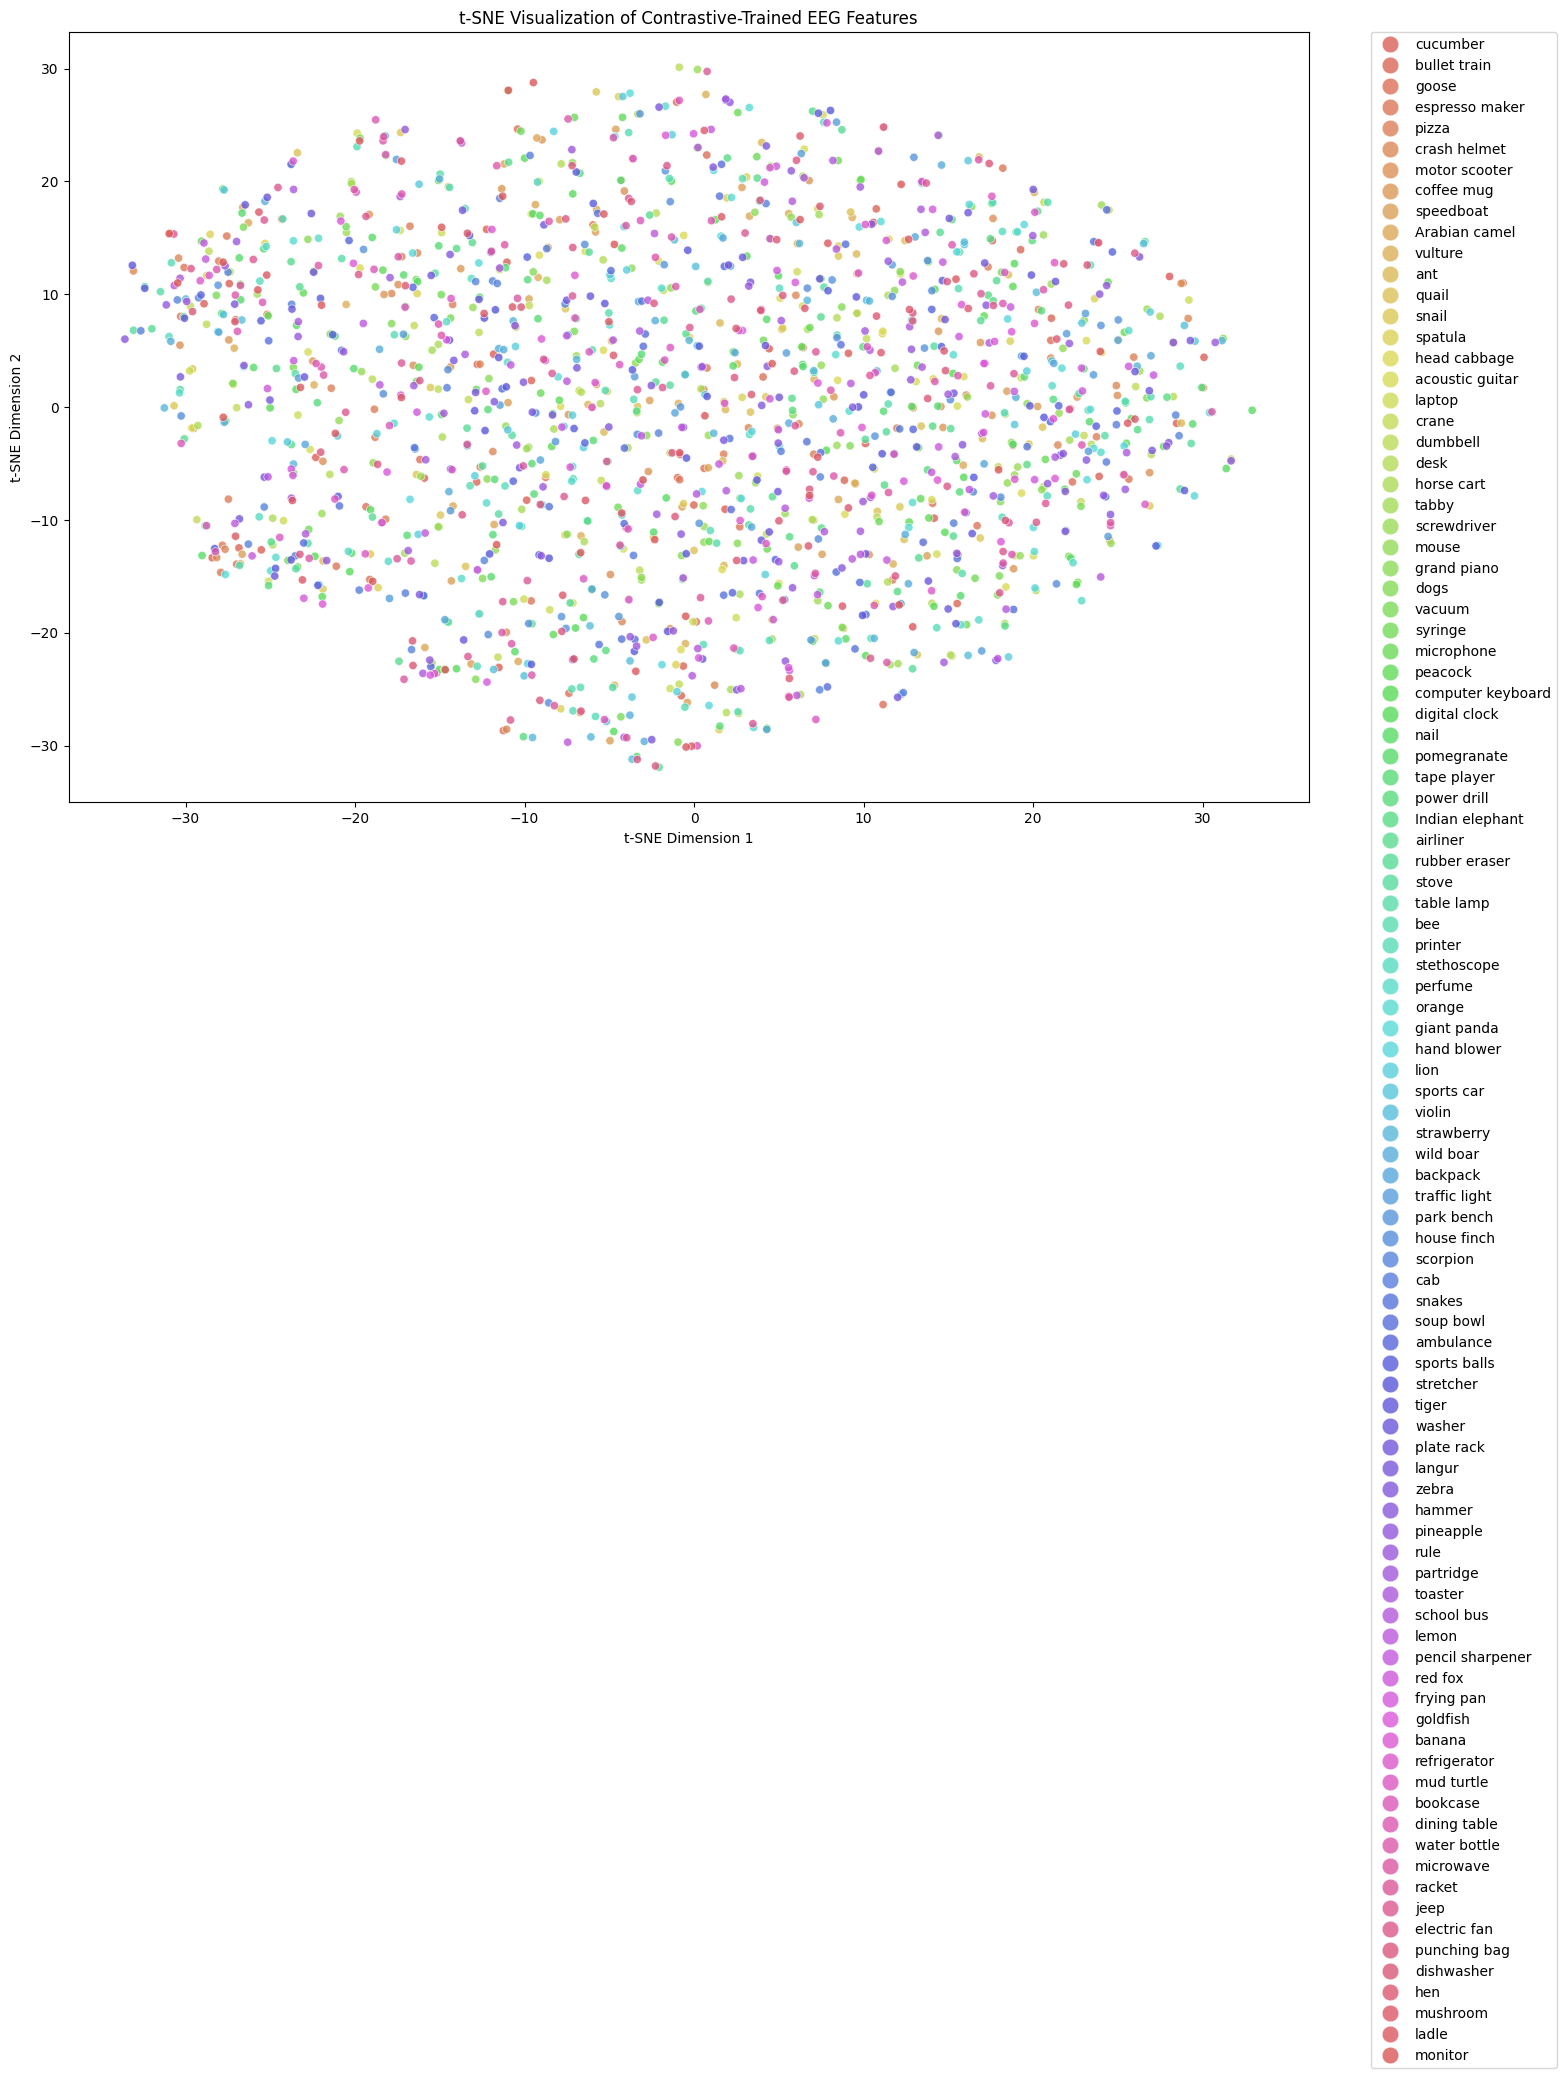

In [ ]:
import torch
import timm
import numpy as np
import pandas as pd
from pathlib import Path
from collections import OrderedDict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
import os

# ==============================================================================
# --- 1. CONFIGURATION FOR T-SNE ANALYSIS ---
# ==============================================================================
class CONFIG_TSNE_CONTRASTIVE:
    # --- UPDATE THIS PATH ---
    # Point this to the '.pth' file saved by the contrastive training script
    CONTRASTIVE_ENCODER_PATH = '/content/drive/MyDrive/NeuroVision/contrastive_outputs/run_20250912_150114/contrastive_eeg_encoder_best.pth' #<-- UPDATE THIS!

    # --- Other paths (should be correct from before) ---
    CWT_SCALOGRAMS_ROOT = '/content/cwt_scalograms_by_class'
    STATS_MEAN_PATH = '/content/cwt_scalograms_by_class/mean.pt'
    STATS_STD_PATH = '/content/cwt_scalograms_by_class/std.pt'

    # --- Parameters ---
    ENCODER_IMG_SIZE = 224
    EEG_CHANNELS = 4
    BATCH_SIZE = 64
    NUM_SAMPLES_PER_CLASS = 20 # Limit samples to make plotting faster/cleaner.

# ==============================================================================
# --- 2. DATASET (Unchanged) ---
# ==============================================================================
class EEGFeatureDataset(Dataset):
    def __init__(self, eeg_root_dir, eeg_transform, max_per_class=None):
        self.eeg_transform = eeg_transform
        self.samples = self._find_eeg_samples(Path(eeg_root_dir), max_per_class)
        self.class_names = sorted(list(set(s['class_name'] for s in self.samples)))
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

    def _find_eeg_samples(self, eeg_root_dir, max_per_class):
        samples = []
        # We need the 'train' subdirectory
        train_root = eeg_root_dir / 'train'
        for class_dir in train_root.iterdir():
            if class_dir.is_dir():
                paths = list(class_dir.glob('*.pt'))
                if max_per_class:
                    paths = paths[:max_per_class]
                for eeg_file in paths:
                    samples.append({'path': str(eeg_file), 'class_name': class_dir.name})
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        eeg_info = self.samples[idx]
        spectrogram = torch.load(eeg_info['path'])
        if self.eeg_transform:
            spectrogram = self.eeg_transform(spectrogram)
        label = self.class_to_idx[eeg_info['class_name']]
        return spectrogram, label

# ==============================================================================
# --- 3. ANALYSIS SCRIPT (MODIFIED) ---
# ==============================================================================
def analyze_contrastive_features(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Load Encoder (MODIFIED SECTION) ---
    print("Loading contrastive-trained EEG encoder...")
    # 1. Create a new instance of the model architecture
    encoder = timm.create_model('vit_tiny_patch16_224', in_chans=config.EEG_CHANNELS, num_classes=0)

    # 2. Load the saved weights (the state_dict)
    state_dict = torch.load(config.CONTRASTIVE_ENCODER_PATH, map_location='cpu')

    # 3. Load the state_dict into the model instance
    encoder.load_state_dict(state_dict)
    encoder.to(device)
    encoder.eval()
    print("Encoder loaded successfully.")

    # --- Prepare Dataset ---
    print("Preparing dataset and dataloader...")
    mean = torch.load(config.STATS_MEAN_PATH)
    std = torch.load(config.STATS_STD_PATH)
    eeg_transform = transforms.Compose([
        transforms.ToDtype(torch.float32, scale=False),
        transforms.Resize((config.ENCODER_IMG_SIZE, config.ENCODER_IMG_SIZE), antialias=True),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])
    dataset = EEGFeatureDataset(
        eeg_root_dir=Path(config.CWT_SCALOGRAMS_ROOT),
        eeg_transform=eeg_transform,
        max_per_class=config.NUM_SAMPLES_PER_CLASS
    )
    dataloader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    print(f"Found {len(dataset.class_names)} classes.")

    # --- Extract Features ---
    print("Extracting features from all samples...")
    all_features = []
    all_labels = []
    with torch.no_grad():
        for spectrograms, labels in tqdm(dataloader, desc="Extracting Features"):
            spectrograms = spectrograms.to(device)
            features = encoder.forward_features(spectrograms)[:, 0] # Get [CLS] token
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_features = np.concatenate(all_features)
    all_labels = np.concatenate(all_labels)
    print(f"Extracted {all_features.shape[0]} feature vectors.")

    # --- Run t-SNE ---
    print("Running t-SNE... (This may take a few minutes)")
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=400, learning_rate='auto', init='pca')
    tsne_results = tsne.fit_transform(all_features)
    print("t-SNE complete.")

    # --- Plot Results ---
    print("Generating plot...")
    df = pd.DataFrame()
    df['tsne-2d-one'] = tsne_results[:,0]
    df['tsne-2d-two'] = tsne_results[:,1]
    df['label'] = [dataset.class_names[i] for i in all_labels]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="label",
        palette=sns.color_palette("hls", len(dataset.class_names)),
        data=df,
        legend="full",
        alpha=0.8
    )
    plt.title("t-SNE Visualization of Contrastive-Trained EEG Features")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    # Adjust legend to prevent it from overlapping with the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
    plt.tight_layout(rect=[0,0,0.85,1]) # Adjust layout to make room for legend
    plt.show()

# ==============================================================================
# --- 4. EXECUTION ---
# ==============================================================================
if __name__ == '__main__':
    # Make sure to update the path in the config class above
    tsne_config = CONFIG_TSNE_CONTRASTIVE()
    analyze_contrastive_features(tsne_config)

## Contrastive Training

In [ ]:
# import os
# import torch
# import timm
# import pandas as pd
# from pathlib import Path
# from collections import OrderedDict
# from datetime import datetime
# from sklearn.model_selection import train_test_split
# from tqdm.notebook import tqdm
# from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import v2 as transforms
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
# from PIL import Image
# import random
# import torch.nn.functional as F

# # ==============================================================================
# # --- 1. CONFIGURATION for Contrastive Learning ---
# # ==============================================================================
# class CONFIG_CONTRASTIVE:
#     # --- UPDATE THESE PATHS ---
#     PRETRAINED_EEG_ENCODER_PATH = '/content/drive/MyDrive/NeuroVision/models/pretrain_encoder_20250905_194203_best.pth'
#     CWT_SCALOGRAMS_ROOT = '/content/cwt_scalograms_by_class/train'
#     IMAGE_ROOT_DIR = '/content/gan_imagenet' # Your original image folder
#     STATS_MEAN_PATH = '/content/cwt_scalograms_by_class/mean.pt'
#     STATS_STD_PATH = '/content/cwt_scalograms_by_class/std.pt'

#     # --- Output Paths ---
#     OUTPUT_DIR = '/content/drive/MyDrive/NeuroVision/contrastive_outputs'

#     # --- Hyperparameters ---
#     LR = 1e-5 # A smaller LR is often better for contrastive fine-tuning
#     WEIGHT_DECAY = 0.02
#     BATCH_SIZE = 48 # A moderate batch size is crucial for good negative sampling
#     NUM_EPOCHS = 150
#     IMG_SIZE = 224
#     EEG_CHANNELS = 4

#     # --- Model Dimensions ---
#     ENCODER_DIM = 192 # Output dim of ViT-Tiny
#     PROJECTION_DIM = 256 # The dimension of the shared embedding space

# # ==============================================================================
# # --- 2. MODEL DEFINITIONS ---
# # ==============================================================================
# class ProjectionHead(nn.Module):
#     """ Projects the encoder's features into the shared embedding space. """
#     def __init__(self, embedding_dim, projection_dim):
#         super().__init__()
#         self.projection = nn.Linear(embedding_dim, projection_dim)
#         self.gelu = nn.GELU()
#         self.fc = nn.Linear(projection_dim, projection_dim)
#         self.dropout = nn.Dropout(0.1)
#         self.layer_norm = nn.LayerNorm(projection_dim)

#     def forward(self, x):
#         projected = self.projection(x)
#         x = self.gelu(projected)
#         x = self.fc(x)
#         x = self.dropout(x)
#         x = x + projected # Add residual connection
#         x = self.layer_norm(x)
#         return x

# class ContrastiveLoss(nn.Module):
#     """ The loss function for contrastive learning. """
#     def __init__(self, temperature=0.07):
#         super().__init__()
#         self.temperature = nn.Parameter(torch.tensor(temperature))

#     def forward(self, eeg_embeddings, image_embeddings):
#         # Normalize the embeddings to have unit length
#         eeg_embeddings = F.normalize(eeg_embeddings, p=2, dim=1)
#         image_embeddings = F.normalize(image_embeddings, p=2, dim=1)

#         # Calculate the similarity matrix
#         logits = (eeg_embeddings @ image_embeddings.T) / self.temperature

#         # The labels are the diagonal elements (positive pairs)
#         labels = torch.arange(len(logits)).to(logits.device)

#         # Calculate loss in both directions (EEG->Image and Image->EEG)
#         loss_eeg = F.cross_entropy(logits, labels)
#         loss_image = F.cross_entropy(logits.T, labels)

#         return (loss_eeg + loss_image) / 2

# # ==============================================================================
# # --- 3. DATASET CLASS ---
# # ==============================================================================
# class EEGImageContrastiveDataset(Dataset):
#     def __init__(self, eeg_root_dir, image_root_dir, eeg_transform, image_transform):
#         self.eeg_transform = eeg_transform
#         self.image_transform = image_transform
#         self.samples = self._create_samples(Path(eeg_root_dir), Path(image_root_dir))

#     def _create_samples(self, eeg_root, image_root):
#         samples = []
#         image_map = {d.name: [str(p) for p in d.glob('*.*')] for d in image_root.iterdir() if d.is_dir()}

#         for class_dir in eeg_root.iterdir():
#             if class_dir.is_dir() and class_dir.name in image_map:
#                 image_paths = image_map[class_dir.name]
#                 for eeg_file in class_dir.glob('*.pt'):
#                     # Each EEG file is paired with a random image from its class
#                     samples.append({'eeg_path': str(eeg_file), 'image_path': random.choice(image_paths)})
#         return samples

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         sample = self.samples[idx]

#         # Load EEG Scalogram
#         eeg_tensor = torch.load(sample['eeg_path'])
#         eeg_tensor = self.eeg_transform(eeg_tensor)

#         # Load Image
#         image = Image.open(sample['image_path']).convert("RGB") # Use RGB for standard pre-trained models
#         image_tensor = self.image_transform(image)

#         return eeg_tensor, image_tensor

# # ==============================================================================
# # --- 4. MAIN TRAINING SCRIPT ---
# # ==============================================================================
# def run_contrastive_training(config):
#     timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     output_dir = os.path.join(config.OUTPUT_DIR, f'run_{timestamp}')
#     model_path = os.path.join(output_dir, f'contrastive_eeg_encoder_best.pth')
#     os.makedirs(output_dir, exist_ok=True)
#     writer = SummaryWriter(os.path.join(output_dir, 'logs'))

#     # --- Prepare Data ---
#     print("1. Preparing data and DataLoaders...")
#     mean = torch.load(config.STATS_MEAN_PATH)
#     std = torch.load(config.STATS_STD_PATH)

#     eeg_transform = transforms.Compose([
#         transforms.ToDtype(torch.float32, scale=False),
#         transforms.Resize((config.IMG_SIZE, config.IMG_SIZE), antialias=True),
#         transforms.Normalize(mean=mean.tolist(), std=std.tolist())
#     ])
#     image_transform = transforms.Compose([
#         transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard ImageNet normalization
#     ])

#     dataset = EEGImageContrastiveDataset(config.CWT_SCALOGRAMS_ROOT, config.IMAGE_ROOT_DIR, eeg_transform, image_transform)
#     loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

#     # --- Initialize Models ---
#     print("2. Initializing models...")
#     # EEG Encoder
#     eeg_encoder = timm.create_model('vit_tiny_patch16_224', in_chans=config.EEG_CHANNELS, num_classes=0)
#     checkpoint = torch.load(config.PRETRAINED_EEG_ENCODER_PATH, map_location='cpu')
#     eeg_encoder.load_state_dict(checkpoint.get('model_state_dict', checkpoint), strict=False)
#     eeg_encoder.to(device)

#     # Image Encoder (pre-trained on ImageNet)
#     image_encoder = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
#     image_encoder.to(device)

#     # Projection Heads
#     eeg_projection = ProjectionHead(config.ENCODER_DIM, config.PROJECTION_DIM).to(device)
#     image_projection = ProjectionHead(config.ENCODER_DIM, config.PROJECTION_DIM).to(device)

#     # --- Training Setup ---
#     criterion = ContrastiveLoss().to(device)
#     # Combine all parameters for the optimizer
#     all_params = list(eeg_encoder.parameters()) + list(image_encoder.parameters()) + \
#                  list(eeg_projection.parameters()) + list(image_projection.parameters())
#     optimizer = optim.AdamW(all_params, lr=config.LR, weight_decay=config.WEIGHT_DECAY)

#     best_loss = float('inf')

#     # --- Training Loop ---
#     print("\n--- Starting Contrastive Learning ---")
#     for epoch in range(config.NUM_EPOCHS):
#         eeg_encoder.train(); image_encoder.train(); eeg_projection.train(); image_projection.train()
#         total_loss = 0.0

#         progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS}")
#         for eeg_tensors, image_tensors in progress_bar:
#             eeg_tensors, image_tensors = eeg_tensors.to(device), image_tensors.to(device)
#             optimizer.zero_grad()

#             # Get feature embeddings
#             eeg_features = eeg_encoder.forward_features(eeg_tensors)[:, 0]
#             image_features = image_encoder.forward_features(image_tensors)[:, 0]

#             # Project to shared space
#             eeg_embeddings = eeg_projection(eeg_features)
#             image_embeddings = image_projection(image_features)

#             loss = criterion(eeg_embeddings, image_embeddings)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()
#             progress_bar.set_postfix(Loss=f"{loss.item():.4f}")

#         avg_loss = total_loss / len(loader)
#         writer.add_scalar('Loss/train', avg_loss, epoch)
#         print(f"Epoch {epoch+1}: Average Loss: {avg_loss:.4f}")

#         # Save the best model based on loss
#         if avg_loss < best_loss:
#             best_loss = avg_loss
#             print(f"New best loss ({best_loss:.4f}). Saving EEG encoder to {model_path}")
#             torch.save(eeg_encoder.state_dict(), model_path)

#     writer.close()
#     print(f"--- Training complete. Best model saved to {model_path} ---")

# # ==============================================================================
# # --- 5. EXECUTION ---
# # ==============================================================================
# if __name__ == '__main__':
#     cl_config = CONFIG_CONTRASTIVE()
#     run_contrastive_training(cl_config)

In [ ]:
import os
import torch
import timm
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
from PIL import Image
import random
import torch.nn.functional as F
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
import accelerate
import torch.nn as nn
from datetime import datetime
from torchvision.utils import make_grid

# ==============================================================================
# --- 1. CONFIGURATION for Guided Diffusion ---
# ==============================================================================
class CONFIG_DIFFUSION:
    # --- UPDATE THESE PATHS ---
    CONTRASTIVE_ENCODER_PATH = '/content/drive/MyDrive/NeuroVision/contrastive_outputs/run_20250912_150114/contrastive_eeg_encoder_best.pth' #<-- UPDATE THIS!
    CWT_SCALOGRAMS_ROOT = '/content/cwt_scalograms_by_class/train'
    IMAGE_ROOT_DIR = '/content/gan_imagenet'
    STATS_MEAN_PATH = '/content/cwt_scalograms_by_class/mean.pt'
    STATS_STD_PATH = '/content/cwt_scalograms_by_class/std.pt'

    # --- Output Paths ---
    OUTPUT_DIR = '/content/drive/MyDrive/NeuroVision/diffusion_reconstructions'

    # --- Hyperparameters ---
    LR = 1e-4
    BATCH_SIZE = 4 # Reduced to prevent memory issues
    NUM_EPOCHS = 100
    IMG_SIZE = 256
    EEG_CHANNELS = 4
    ENCODER_DIM = 192

    # --- Diffusion Model Settings ---
    MODEL_ID = "CompVis/stable-diffusion-v1-4"
    UNET_CROSS_ATTENTION_DIM = 768
    NUM_INFERENCE_STEPS = 50 # Number of steps for generating sample images

# ==============================================================================
# --- 2. DATASET CLASS (Unchanged) ---
# ==============================================================================
class EEGImageDiffusionDataset(Dataset):
    def __init__(self, eeg_root_dir, image_root_dir, eeg_transform, image_transform):
        self.eeg_transform = eeg_transform
        self.image_transform = image_transform
        eeg_root_path = Path(eeg_root_dir)
        image_root_path = Path(image_root_dir)
        self.samples = self._create_samples(eeg_root_path, image_root_path)
        self.class_to_eeg_paths = {d.name: [str(p) for p in (eeg_root_path/d.name).glob('*.pt')] for d in eeg_root_path.iterdir() if d.is_dir()}

    def _create_samples(self, eeg_root, image_root):
        samples = []
        image_map = {d.name: [str(p) for p in d.glob('*.*')] for d in image_root.iterdir() if d.is_dir()}
        for class_dir in eeg_root.iterdir():
            if class_dir.is_dir() and class_dir.name in image_map:
                image_paths = image_map[class_dir.name]
                for eeg_file in class_dir.glob('*.pt'):
                    samples.append({'eeg_path': str(eeg_file), 'image_path': random.choice(image_paths)})
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        eeg_tensor = torch.load(sample['eeg_path'])
        eeg_tensor = self.eeg_transform(eeg_tensor)
        image = Image.open(sample['image_path']).convert("RGB")
        image_tensor = self.image_transform(image)
        return eeg_tensor, image_tensor

# ==============================================================================
# --- 3. MAIN TRAINING SCRIPT (CORRECTED) ---
# ==============================================================================
def run_diffusion_training(config):
    # --- Setup ---
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_dir = os.path.join(config.OUTPUT_DIR, f'run_{timestamp}')
    samples_dir = os.path.join(output_dir, 'samples')
    model_dir = os.path.join(output_dir, 'model')
    os.makedirs(samples_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    # --- Load Models ---
    print("1. Loading all models...")
    eeg_encoder = timm.create_model('vit_tiny_patch16_224', in_chans=config.EEG_CHANNELS, num_classes=0)
    eeg_encoder.load_state_dict(torch.load(config.CONTRASTIVE_ENCODER_PATH, map_location='cpu'))

    vae = AutoencoderKL.from_pretrained(config.MODEL_ID, subfolder="vae")
    unet = UNet2DConditionModel.from_pretrained(config.MODEL_ID, subfolder="unet")
    noise_scheduler = PNDMScheduler.from_pretrained(config.MODEL_ID, subfolder="scheduler")

    eeg_projection = nn.Linear(config.ENCODER_DIM, config.UNET_CROSS_ATTENTION_DIM)

    vae.requires_grad_(False)
    eeg_encoder.requires_grad_(False)
    unet.requires_grad_(False)
    for name, param in unet.named_parameters():
        if "attn2" in name:
            param.requires_grad_(True)

    # --- Prepare Data ---
    print("2. Preparing dataset and dataloader...")
    mean = torch.load(config.STATS_MEAN_PATH)
    std = torch.load(config.STATS_STD_PATH)

    eeg_transform = transforms.Compose([
        transforms.ToDtype(torch.float32, scale=False),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])
    image_transform = transforms.Compose([
        transforms.Resize(config.IMG_SIZE),
        transforms.CenterCrop(config.IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

    dataset = EEGImageDiffusionDataset(config.CWT_SCALOGRAMS_ROOT, config.IMAGE_ROOT_DIR, eeg_transform, image_transform)
    loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2)

    # --- Prepare for Training ---
    print("3. Setting up optimizer and accelerator...")
    trainable_params = list(eeg_projection.parameters()) + [p for n, p in unet.named_parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(trainable_params, lr=config.LR)

    accelerator = accelerate.Accelerator()
    unet, eeg_projection, optimizer, loader = accelerator.prepare(unet, eeg_projection, optimizer, loader)
    eeg_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # --- Training Loop ---
    print("\n--- Starting Diffusion Model Fine-Tuning ---")
    for epoch in range(config.NUM_EPOCHS):
        unet.train()
        eeg_projection.train()
        progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS}")

        for eeg_tensors, image_tensors in progress_bar:
            with torch.no_grad():
                latents = vae.encode(image_tensors).latent_dist.sample() * vae.config.scaling_factor
                eeg_features = eeg_encoder.forward_features(eeg_tensors)[:, 0]

            eeg_embeddings = eeg_projection(eeg_features)
            eeg_embeddings = eeg_embeddings.unsqueeze(1)

            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=eeg_embeddings).sample

            loss = F.mse_loss(noise_pred, noise)

            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

            progress_bar.set_postfix(Loss=f"{loss.item():.4f}")

        # --- Generate and Save Sample Images ---
        if (epoch + 1) % 5 == 0:
            print(f"Generating sample images for epoch {epoch+1}...")
            unet.eval()
            eeg_projection.eval()
            with torch.no_grad():
                fixed_eeg_tensors = []
                prompt_classes = random.sample(list(dataset.class_to_eeg_paths.keys()), k=min(4, len(dataset.class_to_eeg_paths)))
                for class_name in prompt_classes:
                    eeg_path = random.choice(dataset.class_to_eeg_paths[class_name])
                    eeg_tensor = torch.load(eeg_path)
                    fixed_eeg_tensors.append(eeg_transform(eeg_tensor))

                fixed_eeg_tensors = torch.stack(fixed_eeg_tensors).to(accelerator.device)
                fixed_eeg_features = eeg_encoder.forward_features(fixed_eeg_tensors)[:, 0]

                fixed_eeg_embeddings = eeg_projection(fixed_eeg_features)
                fixed_eeg_embeddings = fixed_eeg_embeddings.unsqueeze(1)

                latents = torch.randn((fixed_eeg_embeddings.shape[0], unet.config.in_channels, config.IMG_SIZE // 8, config.IMG_SIZE // 8), device=accelerator.device)

                # <-- THE FIX IS HERE: Initialize the scheduler's timesteps for inference
                noise_scheduler.set_timesteps(config.NUM_INFERENCE_STEPS)

                for t in tqdm(noise_scheduler.timesteps, desc="Denoising"):
                    noise_pred = unet(latents, t, encoder_hidden_states=fixed_eeg_embeddings).sample
                    latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

                images = vae.decode(latents / vae.config.scaling_factor).sample
                images = (images / 2 + 0.5).clamp(0, 1)

                grid = transforms.ToPILImage()(make_grid(images))
                # Make class names file-system safe
                safe_class_names = [name.replace(" ", "_").replace("/", "_") for name in prompt_classes]
                save_path = os.path.join(samples_dir, f"epoch_{epoch+1}_classes_{'_'.join(safe_class_names)}.png")
                grid.save(save_path)
                print(f"Saved sample grid to {save_path}")

    print("--- Training Complete ---")

# ==============================================================================
# --- 4. EXECUTION ---
# ==============================================================================
if __name__ == '__main__':
    diff_config = CONFIG_DIFFUSION()
    run_diffusion_training(diff_config)

1. Loading all models...
2. Preparing dataset and dataloader...
3. Setting up optimizer and accelerator...

--- Starting Diffusion Model Fine-Tuning ---


Epoch 1/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 5...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_5_classes_microwave_computer_keyboard_airliner_scorpion.png


Epoch 6/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 10...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_10_classes_house_finch_screwdriver_speedboat_microphone.png


Epoch 11/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 15...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_15_classes_dumbbell_pineapple_stethoscope_giant_panda.png


Epoch 16/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 20...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_20_classes_screwdriver_dining_table_bee_mouse.png


Epoch 21/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 25...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_25_classes_snakes_printer_washer_pencil_sharpener.png


Epoch 26/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 30...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_30_classes_pomegranate_airliner_bookcase_pizza.png


Epoch 31/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 35...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_35_classes_stove_bookcase_pomegranate_syringe.png


Epoch 36/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 40...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_40_classes_Indian_elephant_snakes_table_lamp_mud_turtle.png


Epoch 41/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 45...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_45_classes_microwave_red_fox_Arabian_camel_crane.png


Epoch 46/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 50...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_50_classes_vulture_zebra_tiger_bee.png


Epoch 51/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 55...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_55_classes_tabby_strawberry_hammer_lemon.png


Epoch 56/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 60...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_60_classes_washer_soup_bowl_violin_traffic_light.png


Epoch 61/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 65...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_65_classes_hand_blower_bookcase_microphone_crane.png


Epoch 66/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 70...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_70_classes_goose_cab_traffic_light_vacuum.png


Epoch 71/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 75...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_75_classes_head_cabbage_snakes_hand_blower_airliner.png


Epoch 76/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 80...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_80_classes_mouse_computer_keyboard_violin_vulture.png


Epoch 81/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 85...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_85_classes_lion_lemon_red_fox_crash_helmet.png


Epoch 86/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 90...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_90_classes_sports_car_table_lamp_toaster_coffee_mug.png


Epoch 91/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 95...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_95_classes_goose_vacuum_hammer_screwdriver.png


Epoch 96/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/619 [00:00<?, ?it/s]

Generating sample images for epoch 100...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions/run_20250912_171626/samples/epoch_100_classes_Indian_elephant_bullet_train_school_bus_soup_bowl.png
--- Training Complete ---
